In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [3]:
data=pd.read_csv("data up.csv")
data

Date        VIX  Log Total Assets  \
0    12/31/2002  28.210476         13.495030   
1     1/31/2003  27.424286         13.493538   
2     2/28/2003  32.218421         13.488846   
3     3/31/2003  30.634286         13.492065   
4     4/30/2003  23.991905         13.510243   
..          ...        ...               ...   
220   4/30/2021  17.416190         15.866549   
221   5/31/2021  19.760500         15.878174   
222   6/30/2021  16.956818         15.898266   
223   7/31/2021  17.603333         15.918468   
224   8/31/2021  17.472727         15.930789   

     Log Currency in Circulation ($ Bil)  Effective Federal Funds Rate (%)  \
0                               6.516891                          1.238387   
1                               6.521227                          1.235161   
2                               6.521846                          1.262143   
3                               6.527099                          1.252903   
4                               6.532415                          1.258000   
..                                   ...                               ...   
220                             7.675462                          0.069000   
221                             7.681530                          0.058065   
222                             7.686549                          0.078000   
223                             7.689882                          0.098065   
224                             7.690558                          0.092258   

     Loss Function  
0        -4.053360  
1        -3.288373  
2        -3.684400  
3        -3.663571  
4        -4.161742  
..             ...  
220      -2.827729  
221      -1.116398  
222      -1.093716  
223       0.611392  
224       1.117317  

[225 rows x 6 columns]

In [4]:
data = data.set_index('Date')

In [5]:
data

VIX  Log Total Assets  Log Currency in Circulation ($ Bil)  \
Date                                                                           
12/31/2002  28.210476         13.495030                             6.516891   
1/31/2003   27.424286         13.493538                             6.521227   
2/28/2003   32.218421         13.488846                             6.521846   
3/31/2003   30.634286         13.492065                             6.527099   
4/30/2003   23.991905         13.510243                             6.532415   
...               ...               ...                                  ...   
4/30/2021   17.416190         15.866549                             7.675462   
5/31/2021   19.760500         15.878174                             7.681530   
6/30/2021   16.956818         15.898266                             7.686549   
7/31/2021   17.603333         15.918468                             7.689882   
8/31/2021   17.472727         15.930789                             7.690558   

            Effective Federal Funds Rate (%)  Loss Function  
Date                                                         
12/31/2002                          1.238387      -4.053360  
1/31/2003                           1.235161      -3.288373  
2/28/2003                           1.262143      -3.684400  
3/31/2003                           1.252903      -3.663571  
4/30/2003                           1.258000      -4.161742  
...                                      ...            ...  
4/30/2021                           0.069000      -2.827729  
5/31/2021                           0.058065      -1.116398  
6/30/2021                           0.078000      -1.093716  
7/31/2021                           0.098065       0.611392  
8/31/2021                           0.092258       1.117317  

[225 rows x 5 columns]

In [6]:
data_diff = data.diff(year).dropna()
data_diff

VIX  Log Total Assets  Log Currency in Circulation ($ Bil)  \
Date                                                                           
12/31/2003 -11.384113          0.045793                             0.057056   
1/31/2004  -11.323286          0.047454                             0.049309   
2/29/2004  -16.220000          0.043829                             0.047986   
3/31/2004  -12.946894          0.043121                             0.043676   
4/30/2004   -8.293333          0.033697                             0.042352   
...               ...               ...                                  ...   
4/30/2021  -24.037619          0.210753                             0.132517   
5/31/2021  -11.136500          0.124273                             0.116395   
6/30/2021  -14.162727          0.118755                             0.108215   
7/31/2021   -9.237121          0.162716                             0.099906   
8/31/2021   -5.416797          0.172818                             0.087397   

            Effective Federal Funds Rate (%)  Loss Function  
Date                                                         
12/31/2003                         -0.254194       1.032640  
1/31/2004                          -0.238065       0.368954  
2/29/2004                          -0.254901       1.102860  
3/31/2004                          -0.251290       0.404229  
4/30/2004                          -0.254000       1.601901  
...                                      ...            ...  
4/30/2021                           0.020000     112.839893  
5/31/2021                           0.008065      84.519025  
6/30/2021                           0.000333      48.659408  
7/31/2021                           0.005484      39.538836  
8/31/2021                          -0.002903      20.729400  

[213 rows x 5 columns]

In [7]:
data_new = data_diff.diff(year).dropna()

In [8]:
data_new

VIX  Log Total Assets  Log Currency in Circulation ($ Bil)  \
Date                                                                           
12/31/2004   7.017294          0.016904                            -0.006413   
1/31/2005    8.660286          0.012750                             0.000492   
2/28/2005   11.930526          0.016558                             0.002776   
3/31/2005    8.385867          0.017146                             0.008396   
4/30/2005    7.053810          0.019289                             0.007823   
...               ...               ...                                  ...   
4/30/2021  -52.542381         -0.260106                             0.043371   
5/31/2021  -25.311682         -0.460421                             0.008424   
6/30/2021  -29.446273         -0.499225                            -0.009767   
7/31/2021  -22.771667         -0.441530                            -0.024475   
8/31/2021   -9.327229         -0.441747                            -0.048900   

            Effective Federal Funds Rate (%)  Loss Function  
Date                                                         
12/31/2004                          1.426129       0.032383  
1/31/2005                           1.520323       0.889740  
2/28/2005                           1.749446      -0.450845  
3/31/2005                           1.878710       1.480530  
4/30/2005                           2.035000      -0.470287  
...                                      ...            ...  
4/30/2021                           2.394667     228.571523  
5/31/2021                           2.349032     170.165523  
6/30/2021                           2.300333      98.492688  
7/31/2021                           2.315806      78.485753  
8/31/2021                           2.027742      40.409641  

[201 rows x 5 columns]

In [9]:
df = data_new

In [10]:
column_names = {'VIX':'V',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Effective Federal Funds Rate (%)':'FFR', 
                'Loss Function':'LF'}

# rename columns
df = df.rename(columns = column_names)

In [11]:
df

V        TA        CC       FFR          LF
Date                                                           
12/31/2004   7.017294  0.016904 -0.006413  1.426129    0.032383
1/31/2005    8.660286  0.012750  0.000492  1.520323    0.889740
2/28/2005   11.930526  0.016558  0.002776  1.749446   -0.450845
3/31/2005    8.385867  0.017146  0.008396  1.878710    1.480530
4/30/2005    7.053810  0.019289  0.007823  2.035000   -0.470287
...               ...       ...       ...       ...         ...
4/30/2021  -52.542381 -0.260106  0.043371  2.394667  228.571523
5/31/2021  -25.311682 -0.460421  0.008424  2.349032  170.165523
6/30/2021  -29.446273 -0.499225 -0.009767  2.300333   98.492688
7/31/2021  -22.771667 -0.441530 -0.024475  2.315806   78.485753
8/31/2021   -9.327229 -0.441747 -0.048900  2.027742   40.409641

[201 rows x 5 columns]

In [12]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [13]:
residuals

V        TA        CC       FFR          LF
Date                                                           
12/31/2004   9.849021  0.112525 -0.014792  1.754966   -4.395330
1/31/2005   13.077744  0.065692 -0.007423  1.773681   -4.903426
2/28/2005   17.384859  0.051942 -0.005322  2.052677   -7.202058
3/31/2005   15.139816  0.041784 -0.001625  2.030169   -6.030974
4/30/2005   14.196069  0.057093 -0.003338  2.185788   -8.155989
...               ...       ...       ...       ...         ...
4/30/2021  -34.986555  0.230718  0.019126 -1.142877  208.280595
5/31/2021   -5.785034  0.030449  0.018060 -0.366177  144.187619
6/30/2021  -10.050999 -0.014380  0.008812  0.078302   73.532742
7/31/2021   -7.182427  0.072184 -0.007770  0.681436   57.155418
8/31/2021    2.183128  0.085653 -0.023287  1.199790   21.874820

[201 rows x 5 columns]

In [14]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

V    TA    CC   FFR    LF
V    1.00  0.36 -0.23 -0.25  0.04
TA   0.36  1.00  0.78 -0.36 -0.27
CC  -0.23  0.78  1.00  0.24  0.10
FFR -0.25 -0.36  0.24  1.00  0.13
LF   0.04 -0.27  0.10  0.13  1.00

In [ ]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

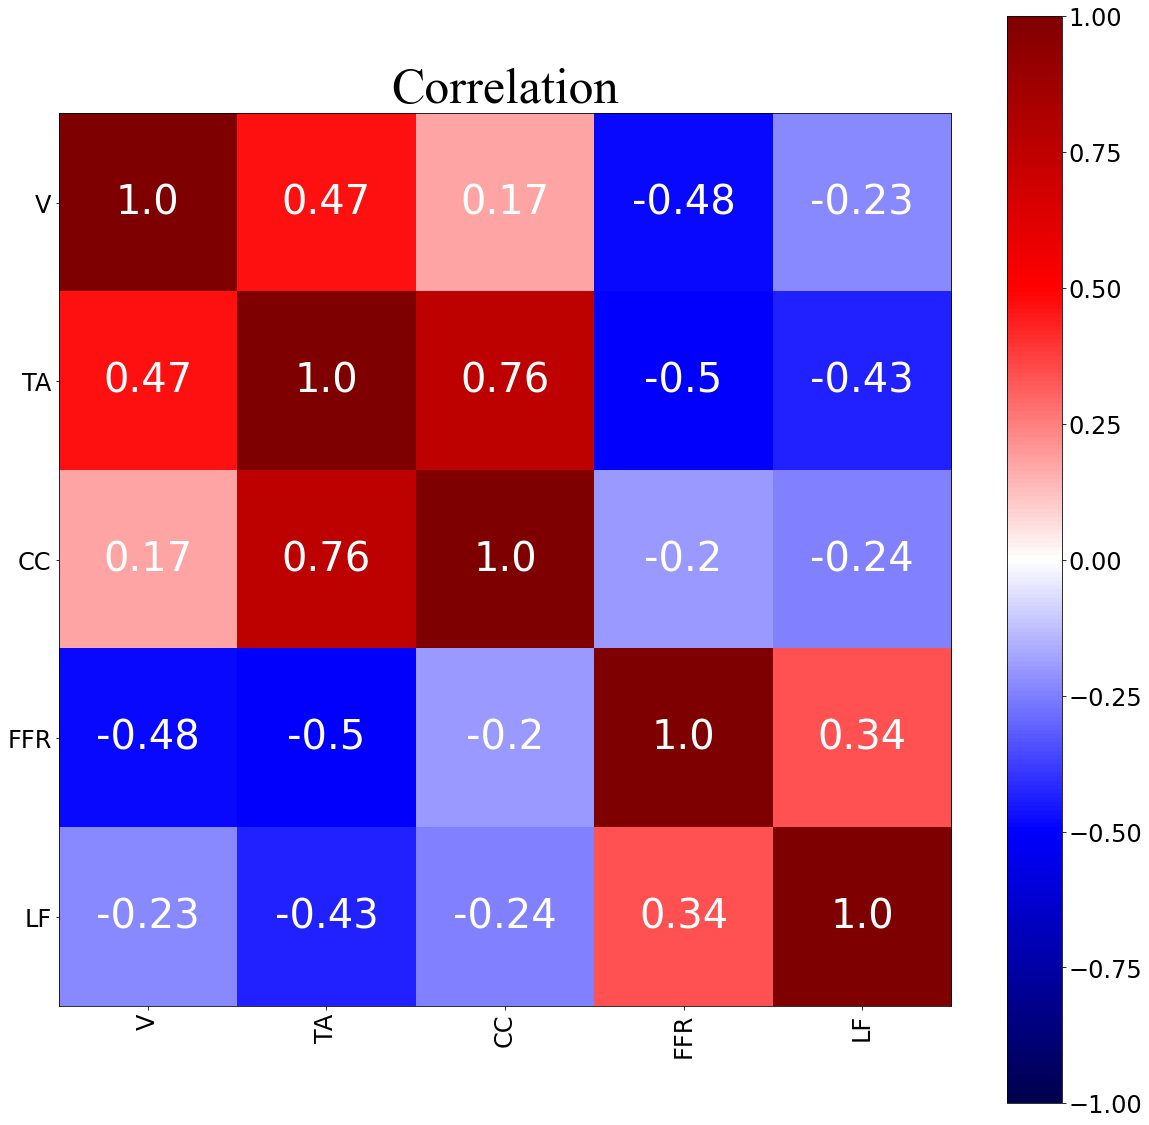

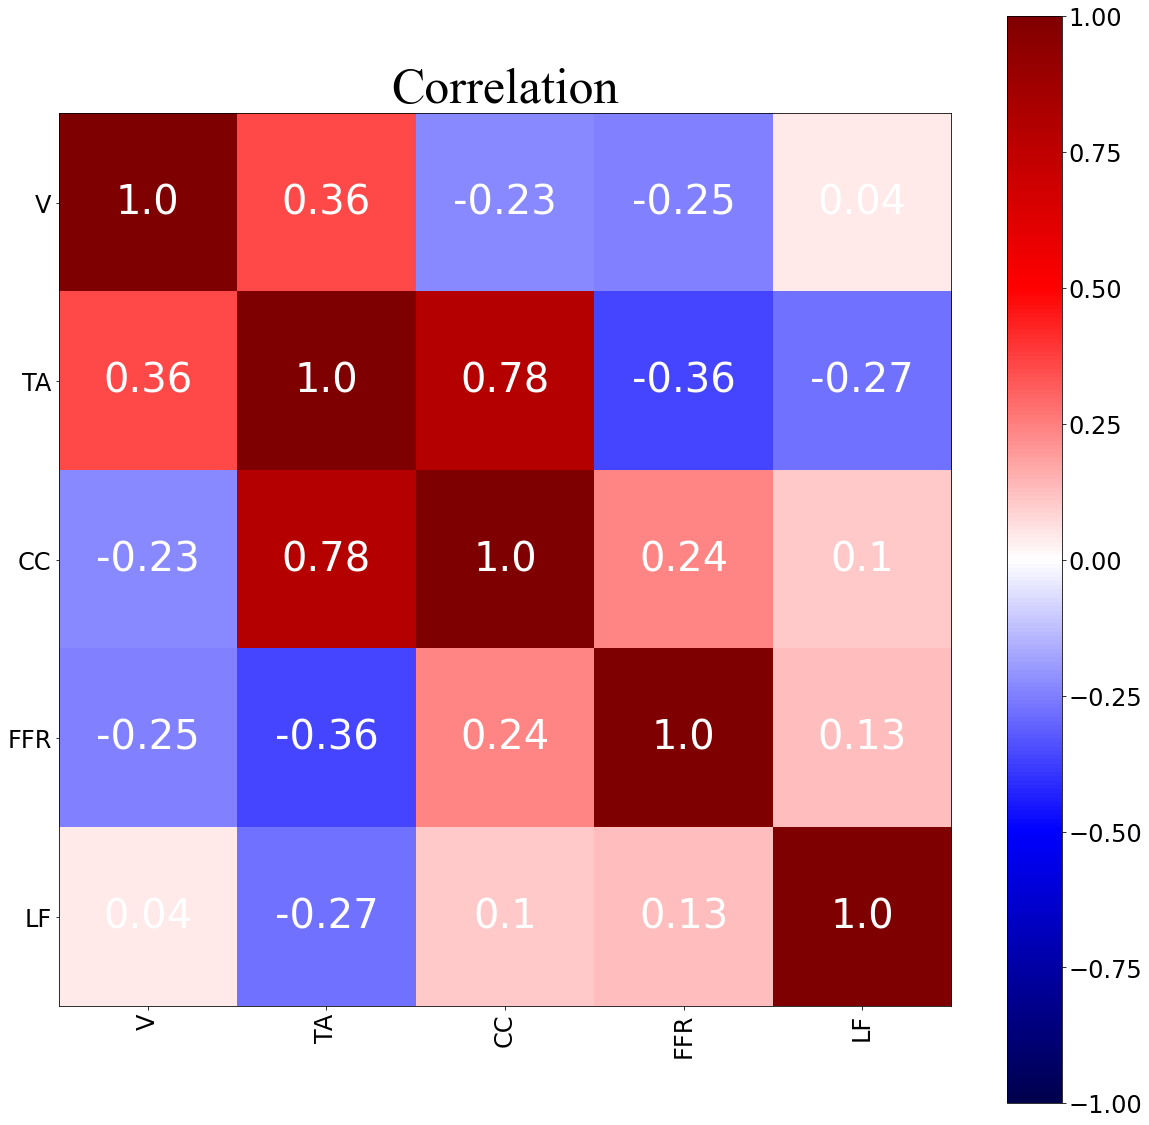

In [16]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None)
corr_matrix_heatmap(df.pcorr(), save_fig = False, pp = None)

In [17]:
residuals

V        TA        CC       FFR          LF
Date                                                           
12/31/2004   9.849021  0.112525 -0.014792  1.754966   -4.395330
1/31/2005   13.077744  0.065692 -0.007423  1.773681   -4.903426
2/28/2005   17.384859  0.051942 -0.005322  2.052677   -7.202058
3/31/2005   15.139816  0.041784 -0.001625  2.030169   -6.030974
4/30/2005   14.196069  0.057093 -0.003338  2.185788   -8.155989
...               ...       ...       ...       ...         ...
4/30/2021  -34.986555  0.230718  0.019126 -1.142877  208.280595
5/31/2021   -5.785034  0.030449  0.018060 -0.366177  144.187619
6/30/2021  -10.050999 -0.014380  0.008812  0.078302   73.532742
7/31/2021   -7.182427  0.072184 -0.007770  0.681436   57.155418
8/31/2021    2.183128  0.085653 -0.023287  1.199790   21.874820

[201 rows x 5 columns]

In [18]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

V   TA    CC   FFR    LF
V     NaN  0.0  0.00  0.00  0.56
TA   0.00  NaN  0.00  0.00  0.00
CC   0.00  0.0   NaN  0.00  0.15
FFR  0.00  0.0  0.00   NaN  0.07
LF   0.56  0.0  0.15  0.07   NaN

In [19]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph

{'V': ['TA', 'CC', 'FFR', 'LF'],
 'TA': ['V', 'CC', 'FFR', 'LF'],
 'CC': ['V', 'TA', 'FFR', 'LF'],
 'FFR': ['V', 'TA', 'CC', 'LF'],
 'LF': ['V', 'TA', 'CC', 'FFR']}

In [20]:
import copy
p_val = .01
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        for c_var in control_vars:
            # set c_used every time use cycle through a new control
            #  the program will then iterate through remaining controls
            #  until statistical significance is broken
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:

                c_used.append(c_var)
                test = df.partial_corr(x = x, y = y, covar=c_used,
                                      method = "pearson")
                if test["p-val"].values[0] > p_val: 

                    undirected_graph[x].remove(y)
                    #breakout of the for 
                    break
                else:
                    remaining_controls = copy.copy(control_vars)
                    remaining_controls.remove(c_var)
                    # recursive function that iterates through remaining variables 
                    #  uses them as controls statistical significance holds without them,
                    #  otherwise break
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
                
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, 
                                       y = y, 
                                       covar = None,
                                       method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'V': ['TA', 'FFR'],
 'TA': ['V', 'CC', 'FFR', 'LF'],
 'CC': ['TA'],
 'FFR': ['V', 'TA'],
 'LF': ['TA']}

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                # edge label is partial correlation between
                # key and key2
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    plt.show()

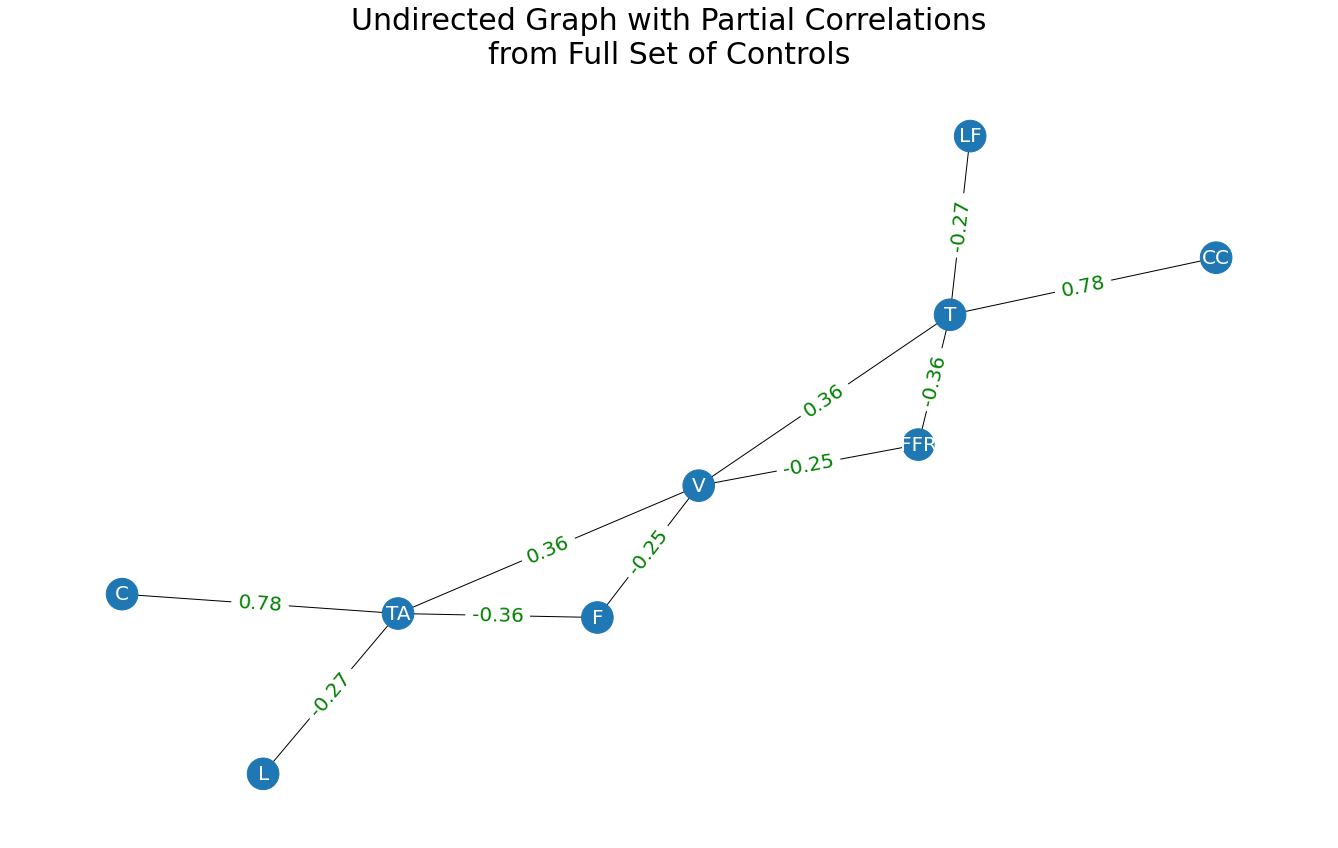

In [22]:
graph_DAG(undirected_graph, df, title = "Undirected Graph with Partial Correlations\nfrom Full Set of Controls")

In [23]:
## Estimating a Directed Acyclic Graph

from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('V', 'TA'), ('FFR', 'TA'), ('FFR', 'V'), ('LF', 'TA'), ('CC', 'TA')])

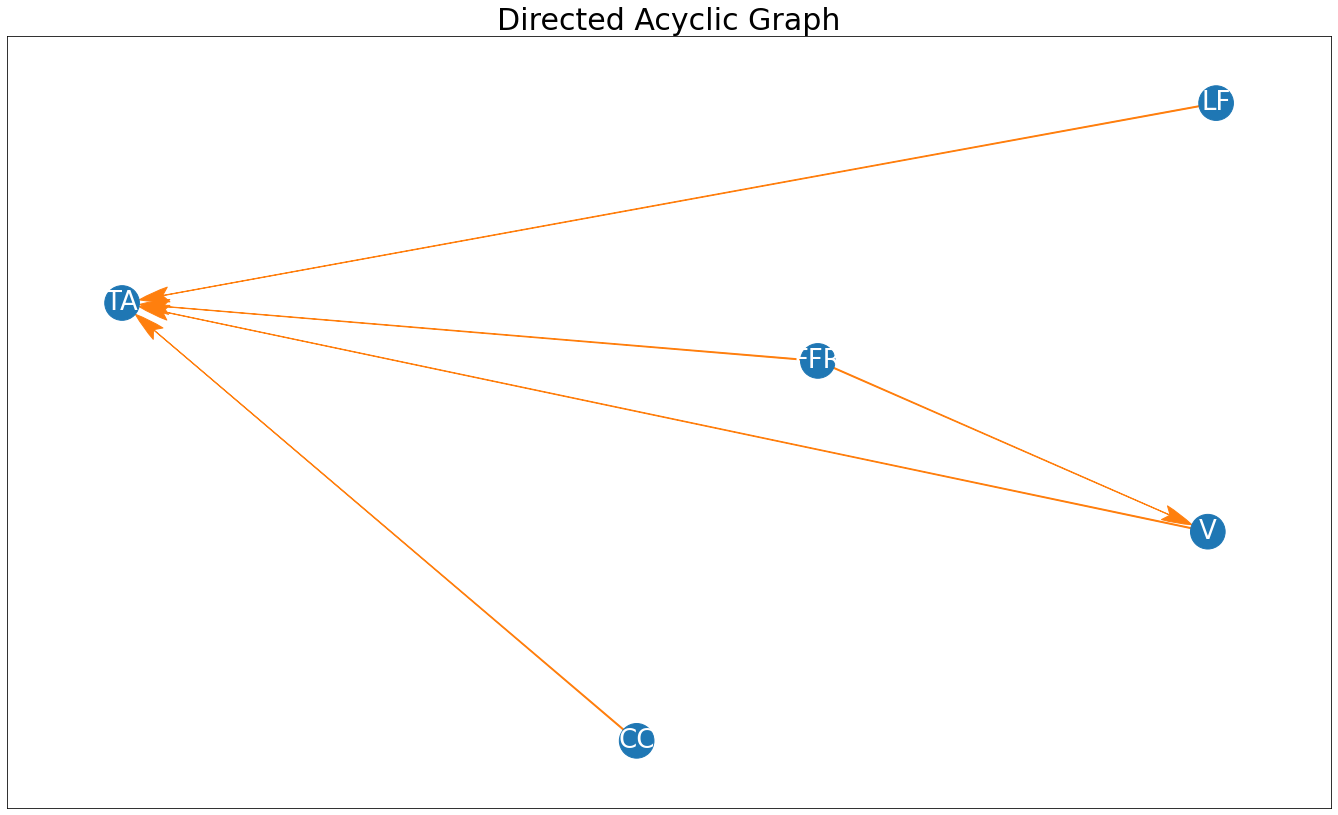

In [24]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: LF
keep control: CC
keep control: FFR
('V', 'TA') ['LF', 'CC', 'FFR']
keep control: LF
keep control: V
keep control: CC
('FFR', 'TA') ['LF', 'V', 'CC']
('FFR', 'V') []
keep control: V
keep control: CC
keep control: FFR
('LF', 'TA') ['V', 'CC', 'FFR']
keep control: LF
keep control: V
keep control: FFR
('CC', 'TA') ['LF', 'V', 'FFR']


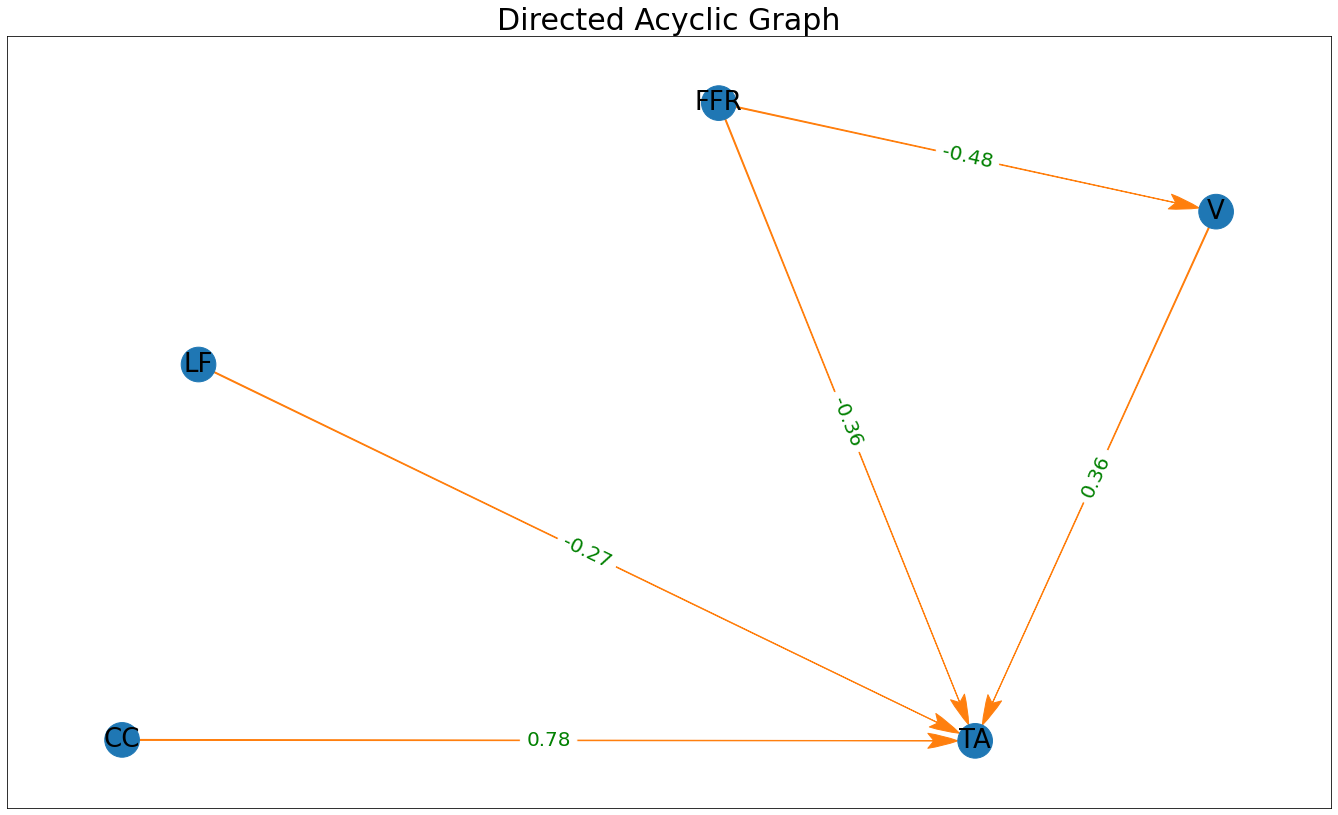

In [25]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\HP\anaconda3\lib\site-packages\pgmpy\base\DAG.py:1187: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

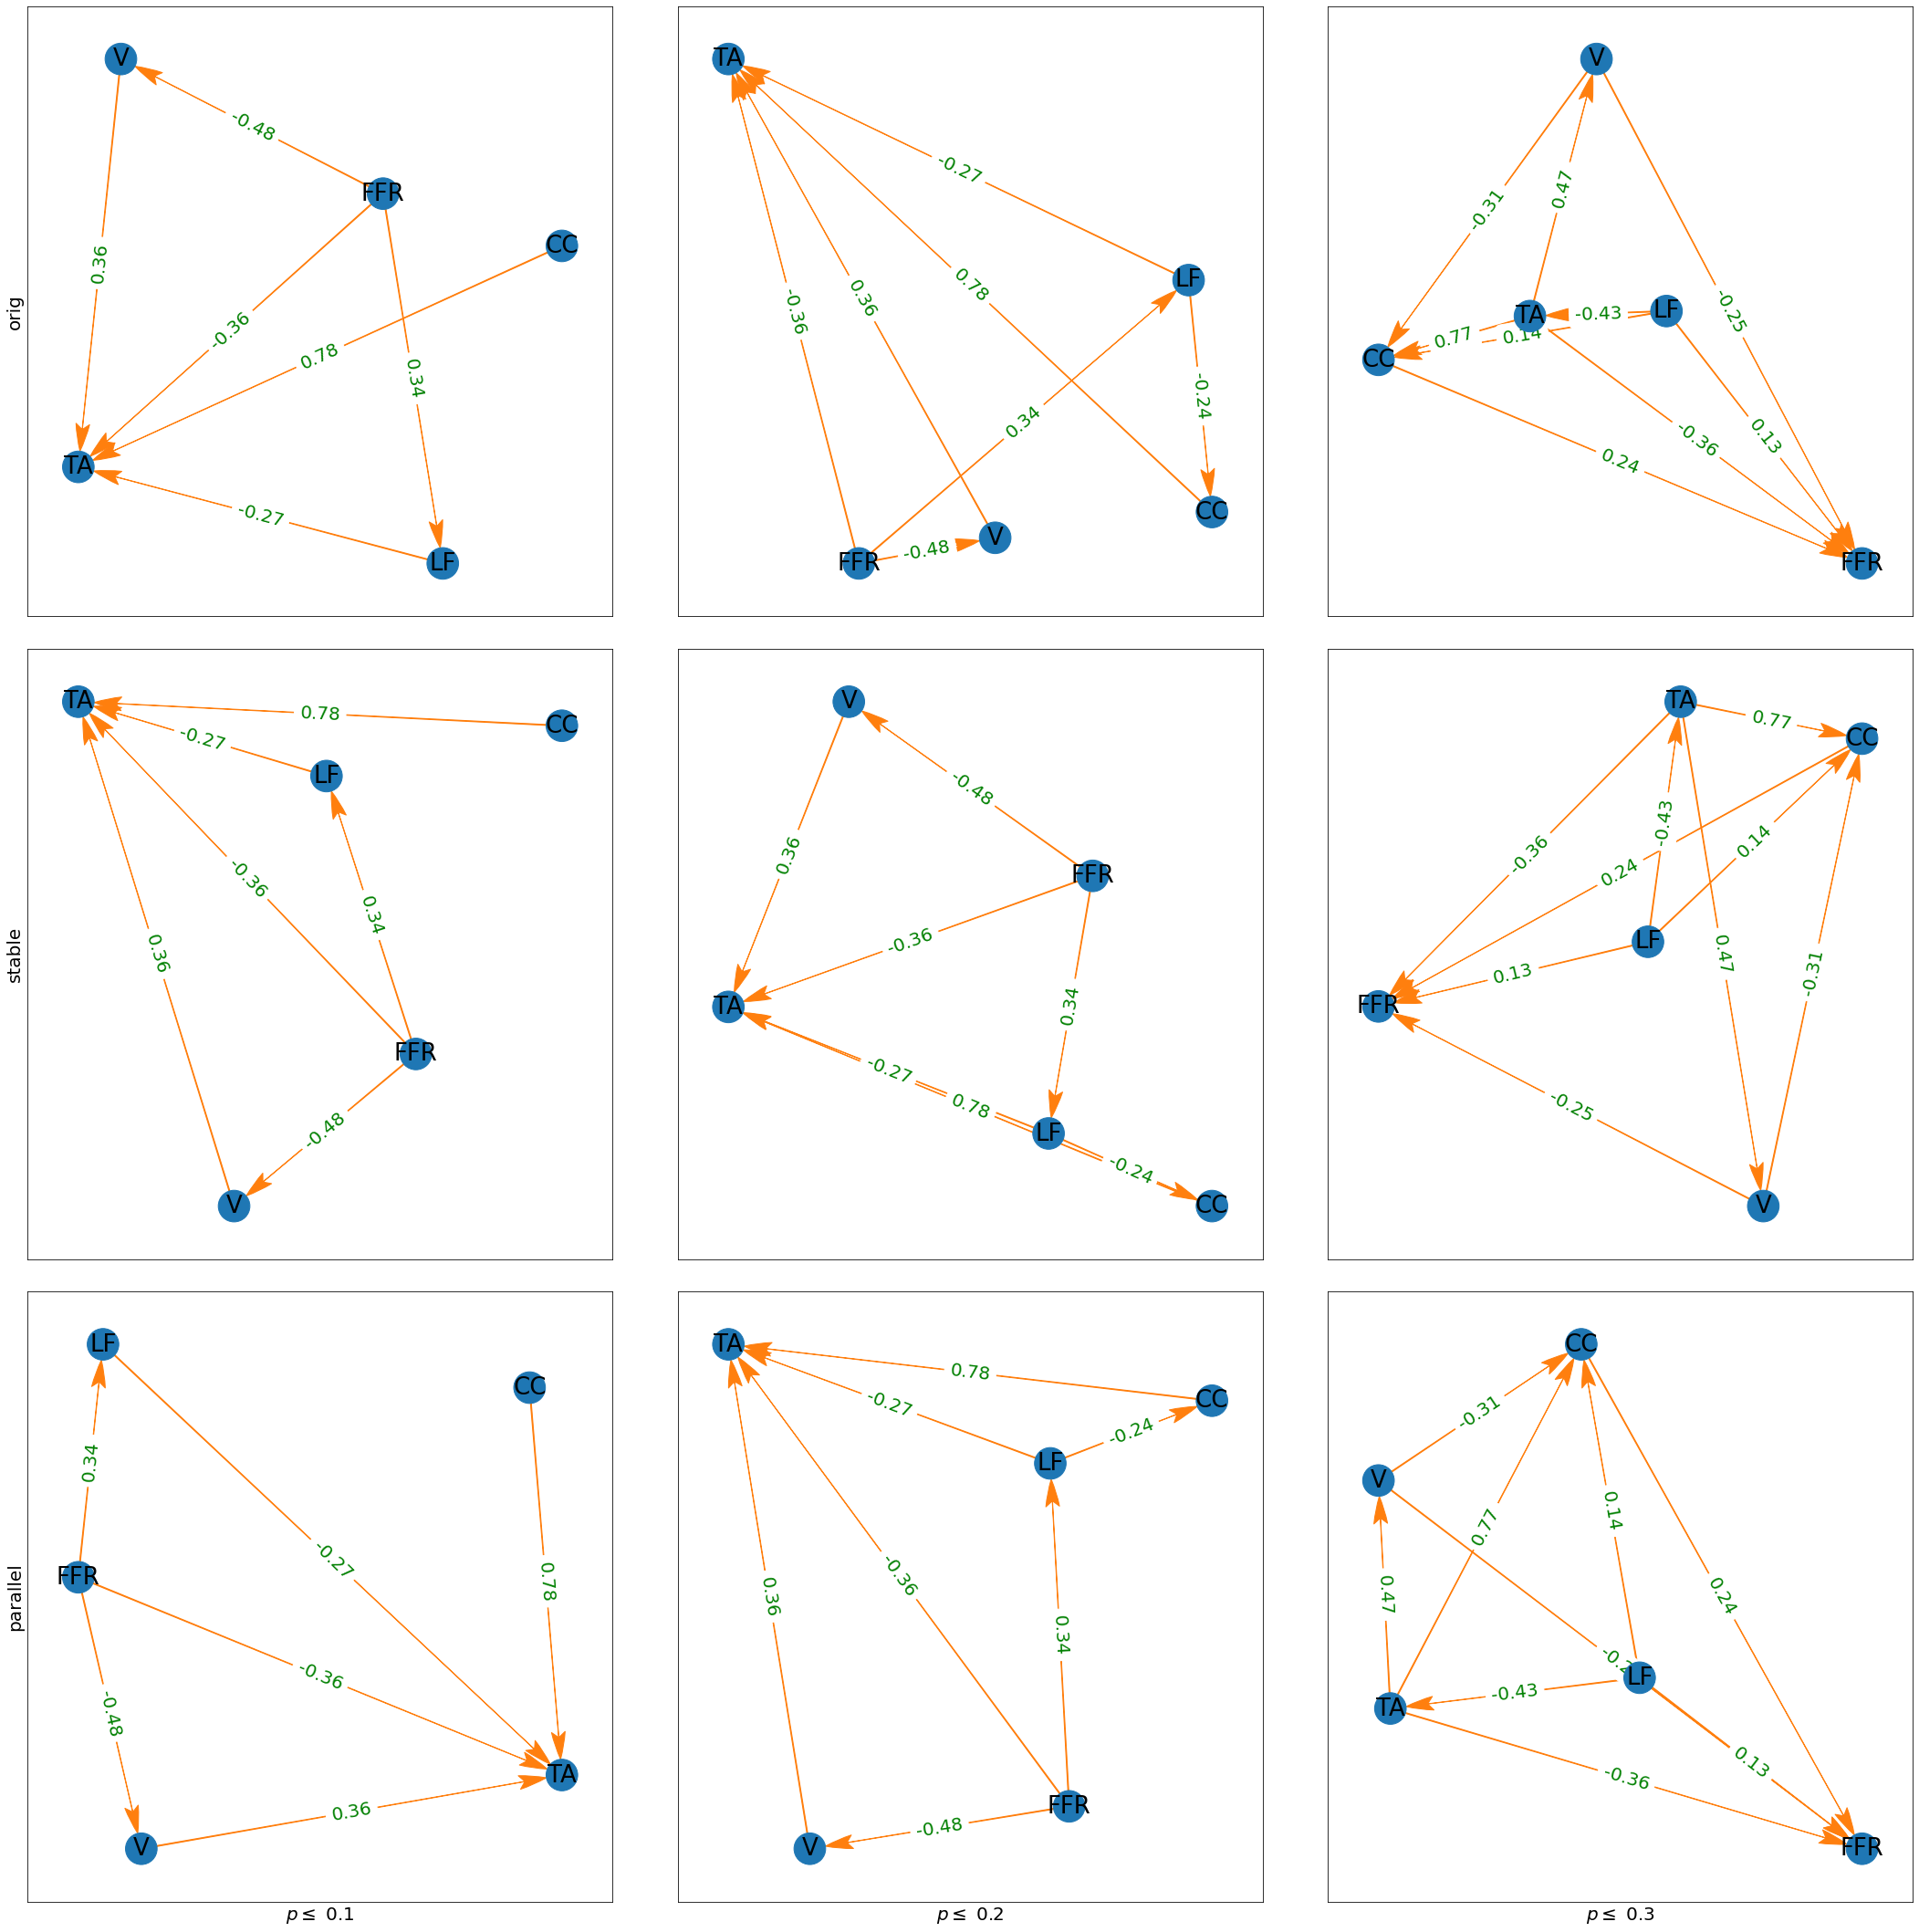

In [27]:
def graph_DAG(edges, df, title = "", fig = False, ax = False):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                keep_controls.append(control)                
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
   
    # add fig and ax if none passed to function
    if not fig and not ax:
        fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
   
    # use ax.set_title to access subplot when setting title
    ax.set_title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle = ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     ax = ax) # reference ax for specific subplot since that is passed as ax to this function
                            # just using plt.title will only add title to very last graph in subplopt
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20,
                                ax = ax)
   
algorithms = ["orig", "stable", "parallel"]
p_vals = [0.1, 0.2, 0.3]
i,j = 0,0
fig, ax = plt.subplots(len(algorithms), len(p_vals), figsize = (30,30))

# use i in range(len(algorithm)) instead of algorithm in algorithms for ax reference (i.e., ax[i])
for i in range(len(algorithms)):
    for j in range(len(p_vals)):
        a = ax[i]
        algorithm = algorithms[i]
        p_val = p_vals[j]
        c = PC(df)
        max_cond_vars = len(df.keys()) - 2
        model = c.estimate(return_type = "dag",
                           variant = algorithm,    
                           significance_level = p_val,
                           max_cond_vars = max_cond_vars,
                           ci_test = "pearsonr")  
        edges = model.edges()
        a = ax[i][j]
        graph_DAG(edges, df, fig = fig, ax = a)
       
        if j == 0:
            a.set_ylabel(algorithm, fontsize = 20)
        if i == len(algorithms) - 1:
            a.set_xlabel("$p \leq$ "+ str(p_val), fontsize = 20)
        if i == 3:
            break

import pingouin as pg
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.estimators import PC
from matplotlib.patches import ArrowStyle

In [28]:
data = df

In [29]:
import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx


def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

# I AM FACING PROBLEMS FROM HERE

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

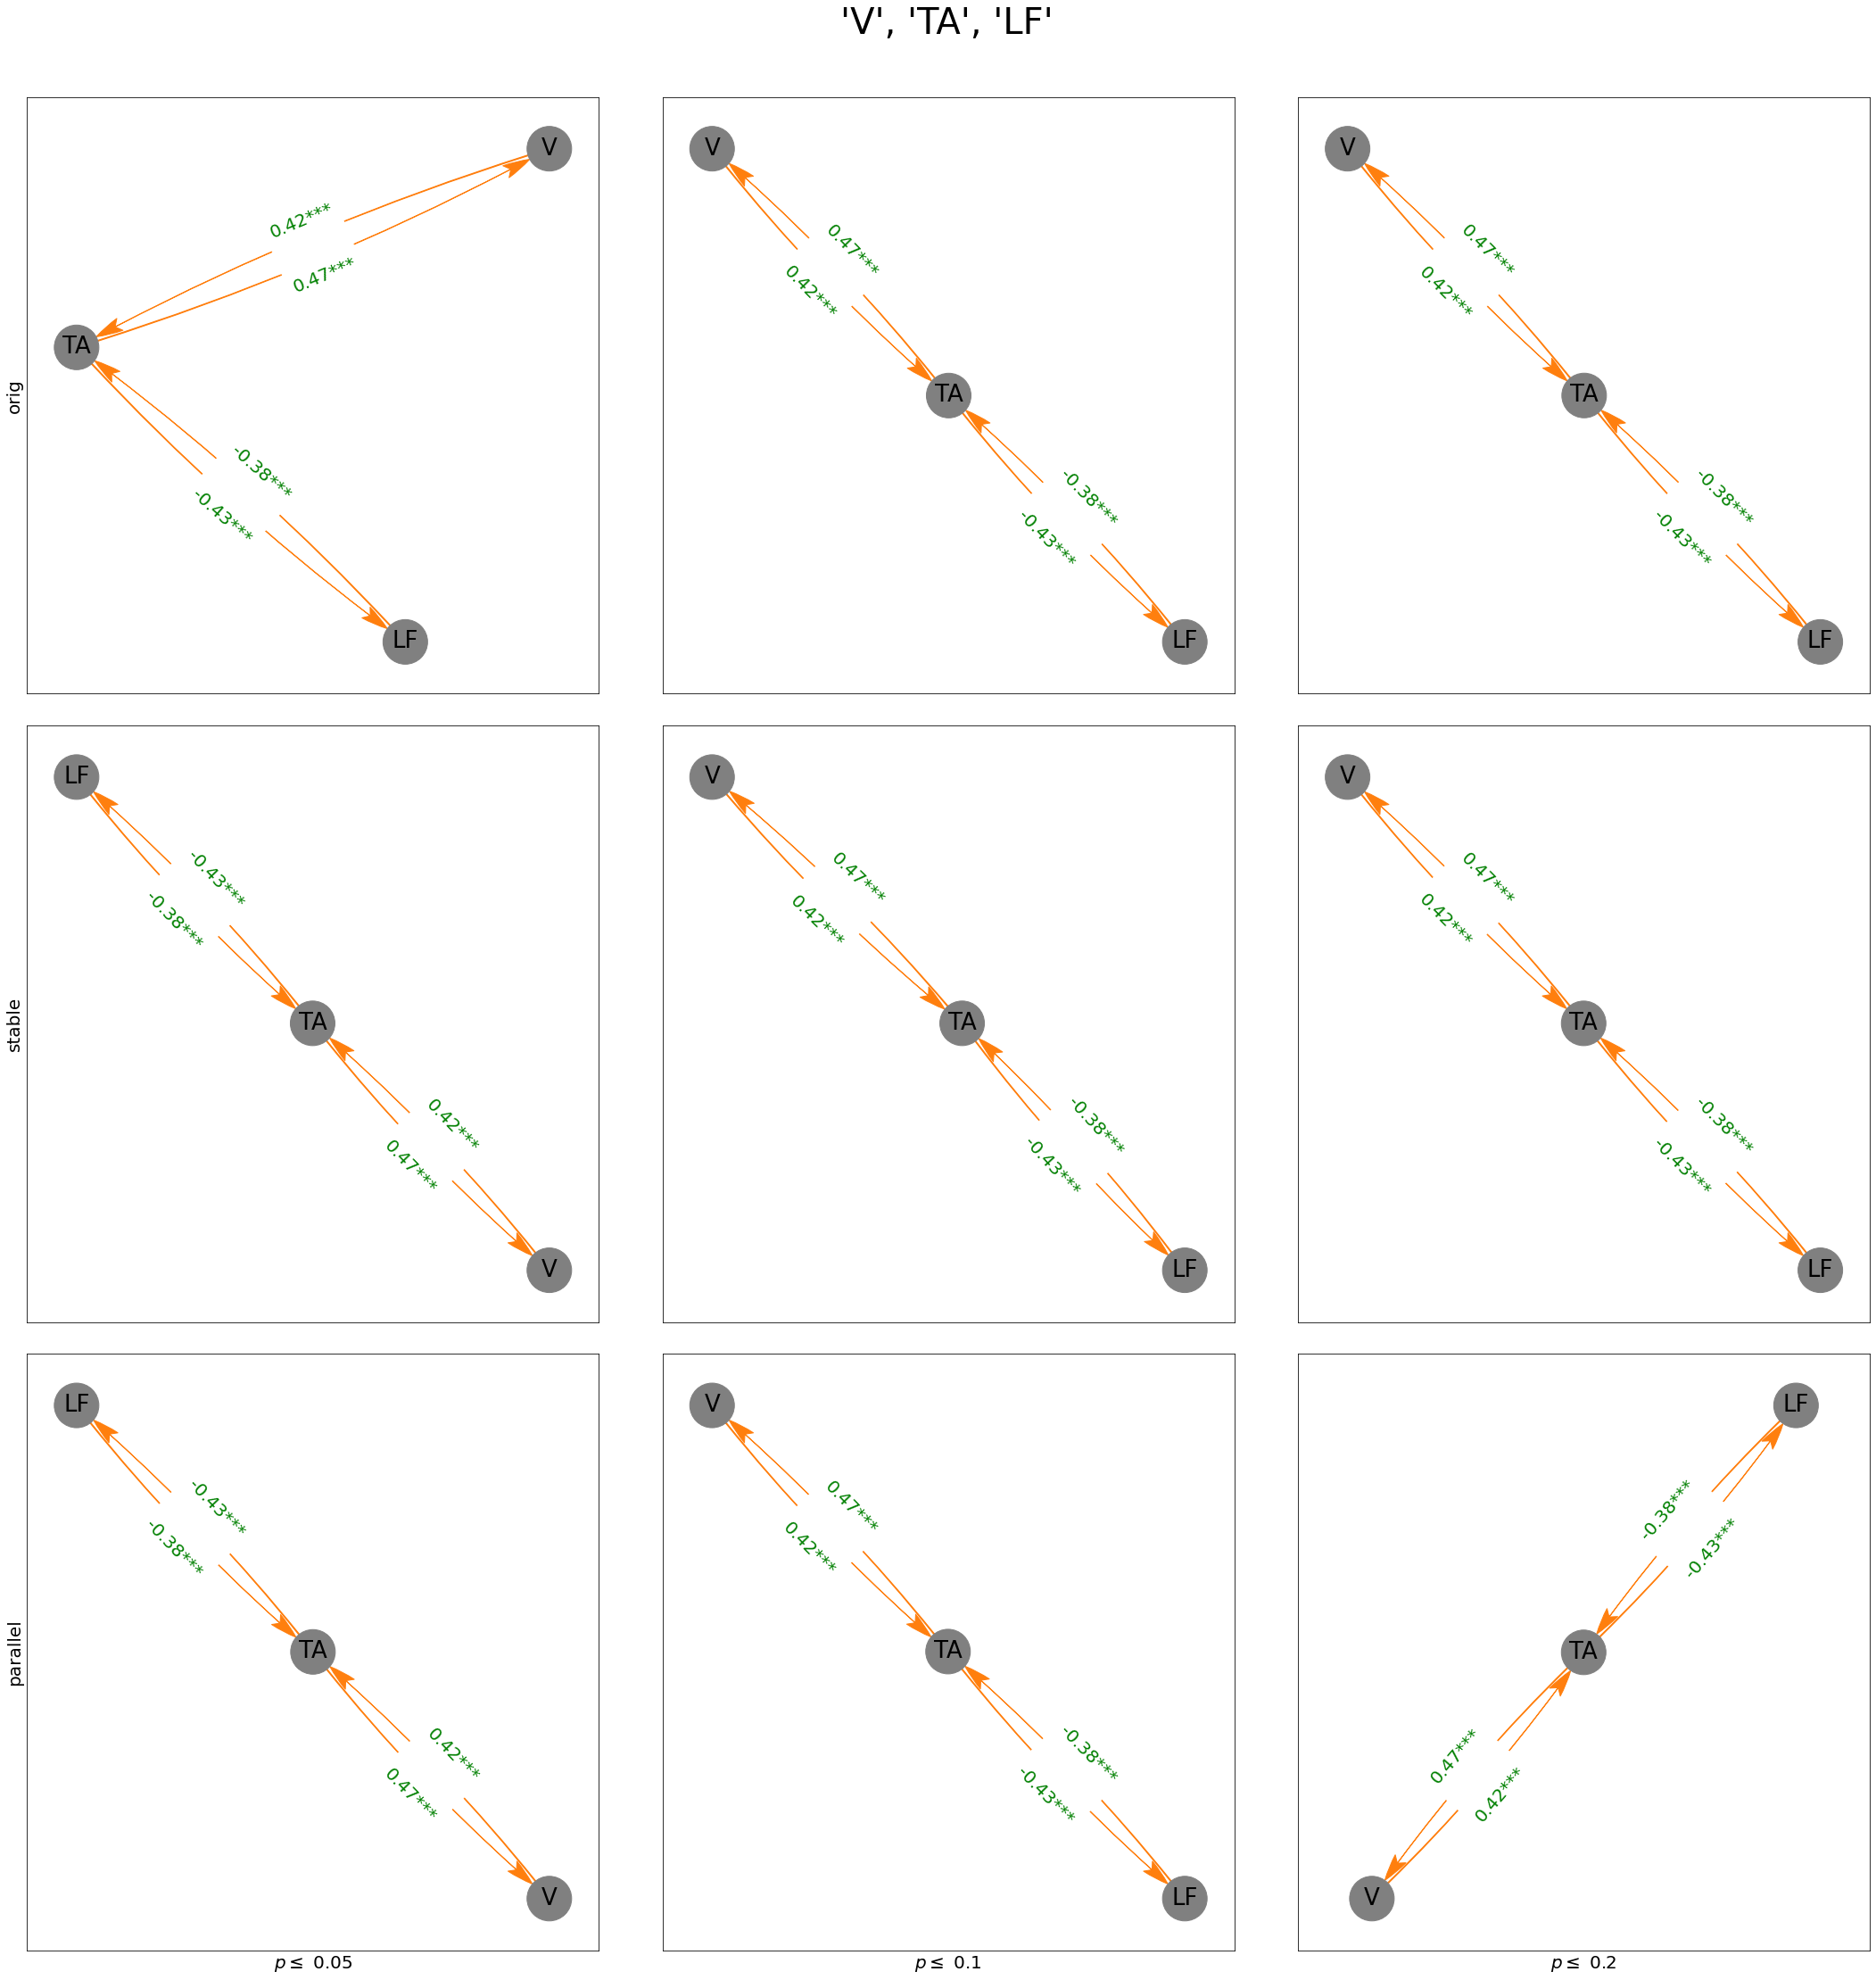

NameError: name 'pp' is not defined

In [30]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    #pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["V", "TA", "LF"],
                  1:["V", "CC", "LF"],
                  2:["V", "FFR", "LF"],
                  3:["TA", "LF", "FFR", "V"],
                  4:["TA", "LF", "FFR", "CC"],
                  5:["TA", "LF", "FFR", "CC","V"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

## I AM FACING PROBLEMS FROM HERE

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

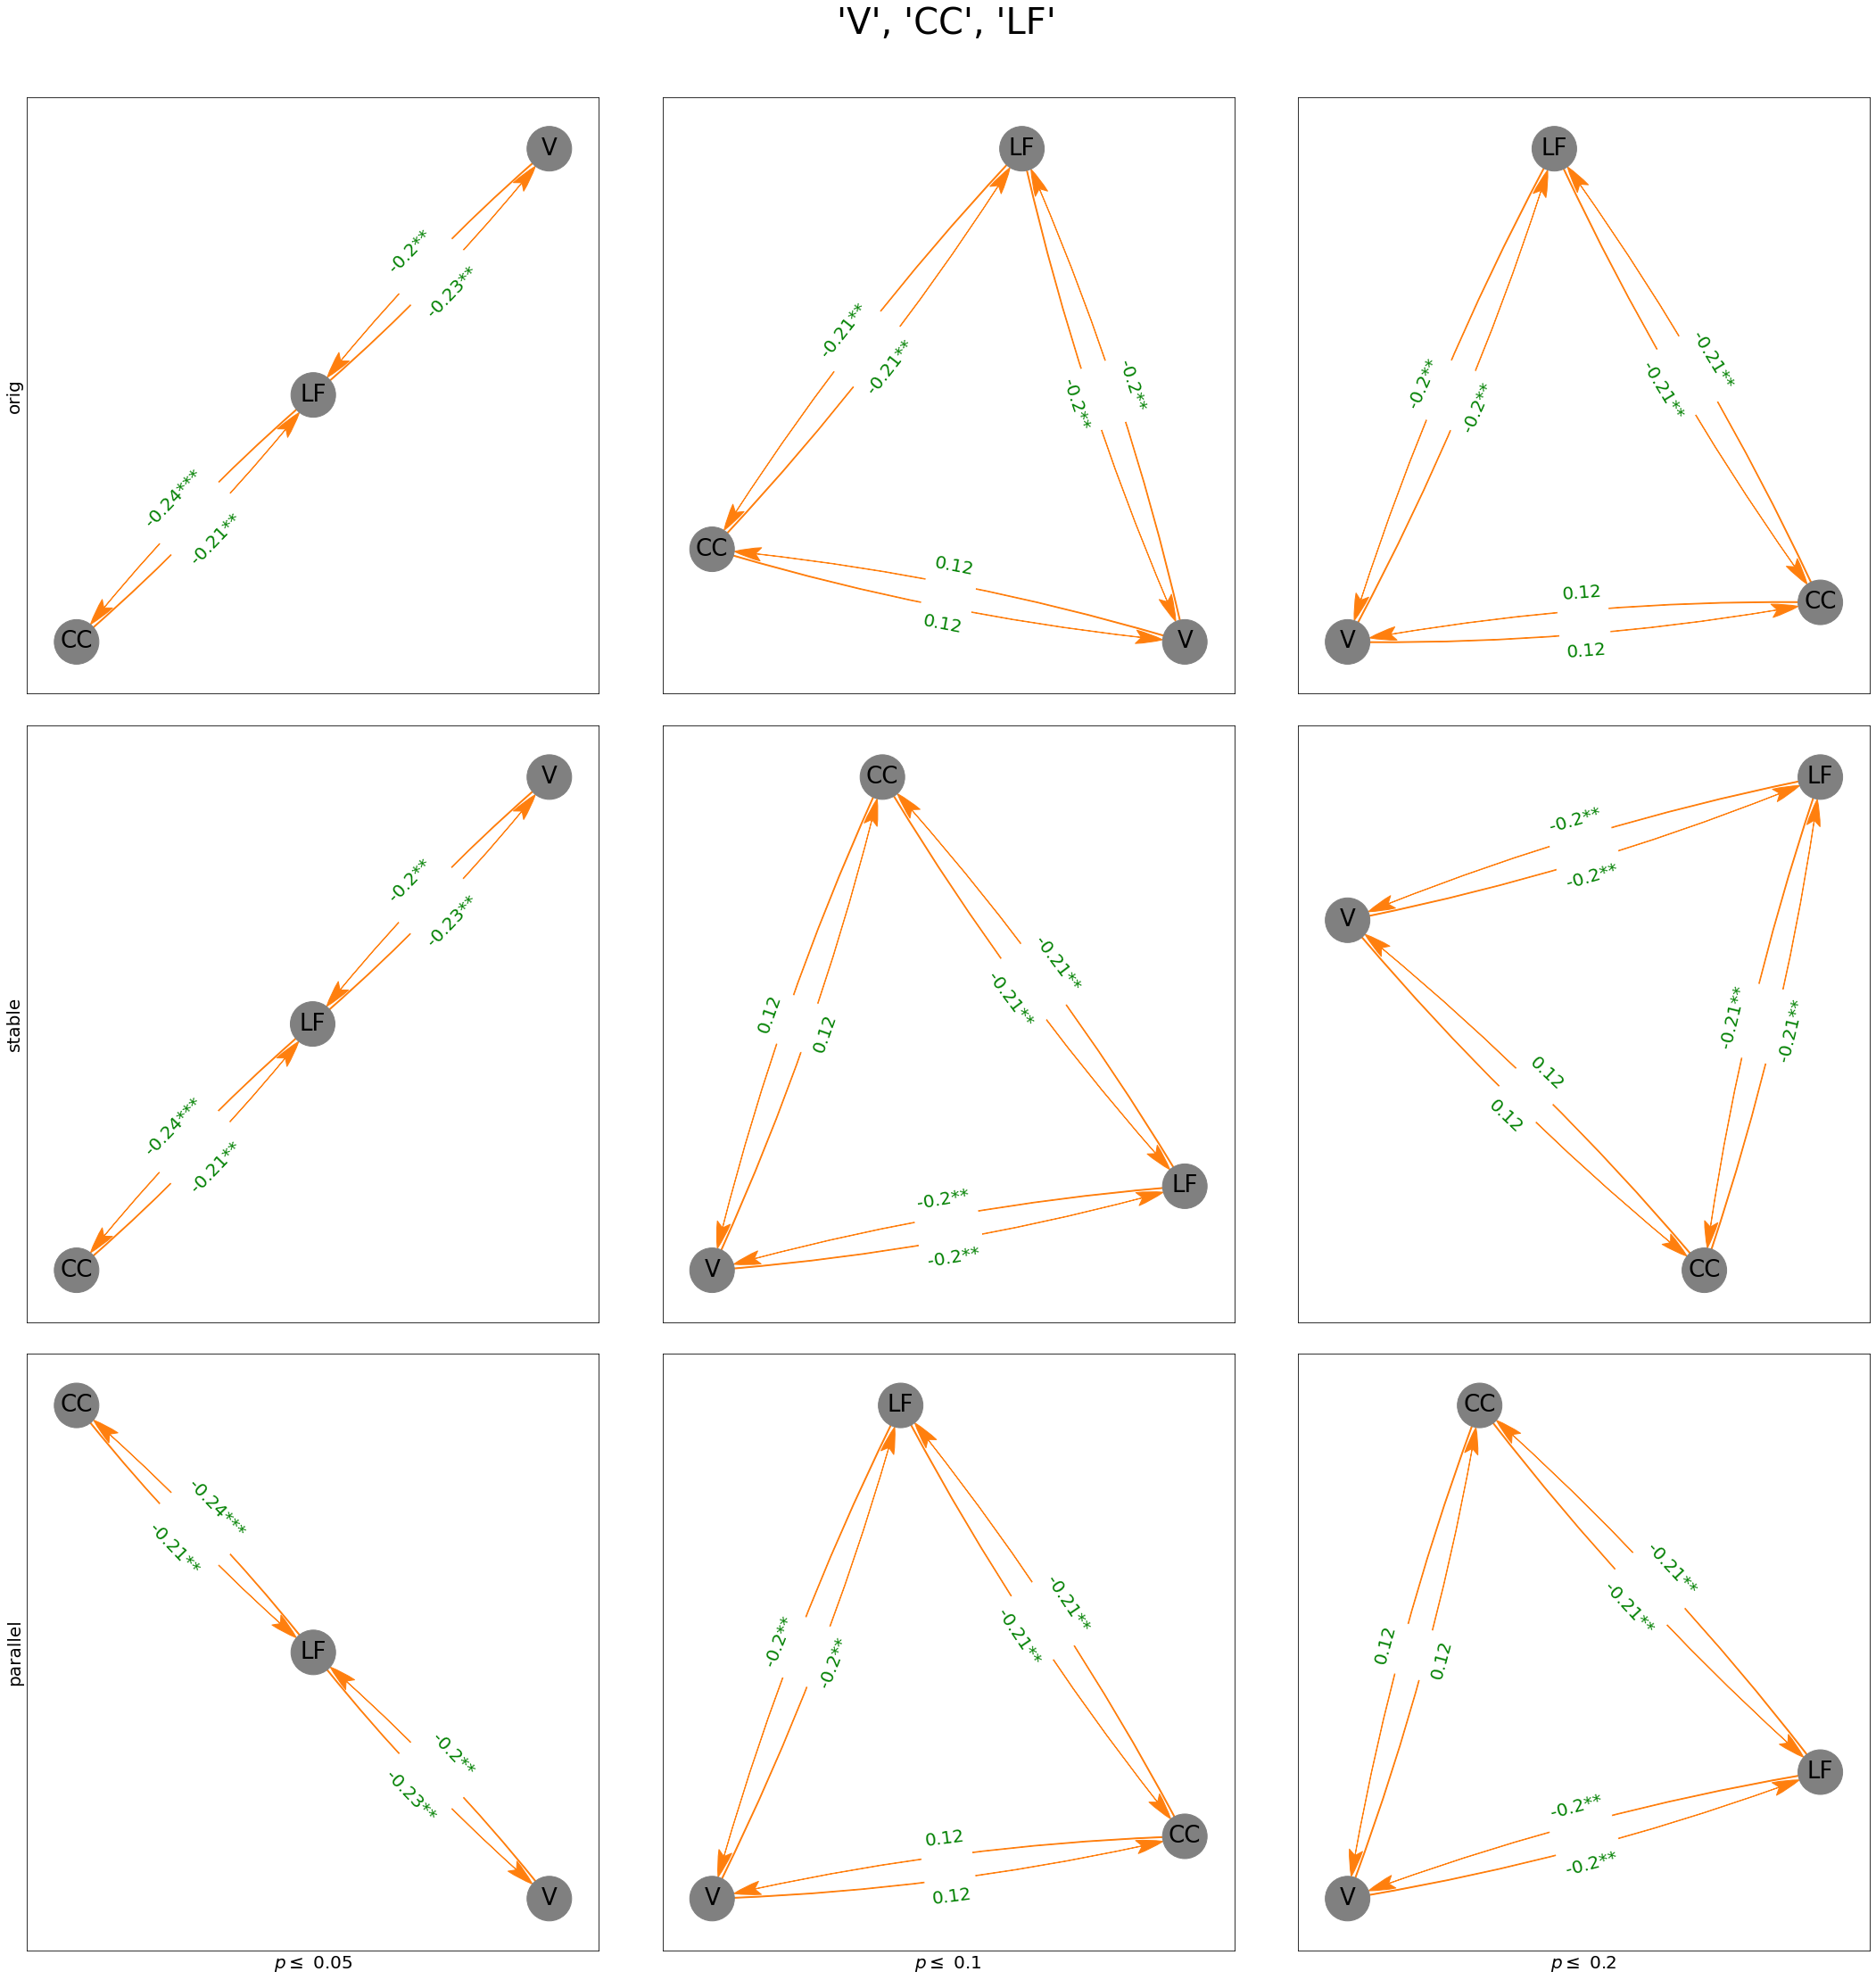

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

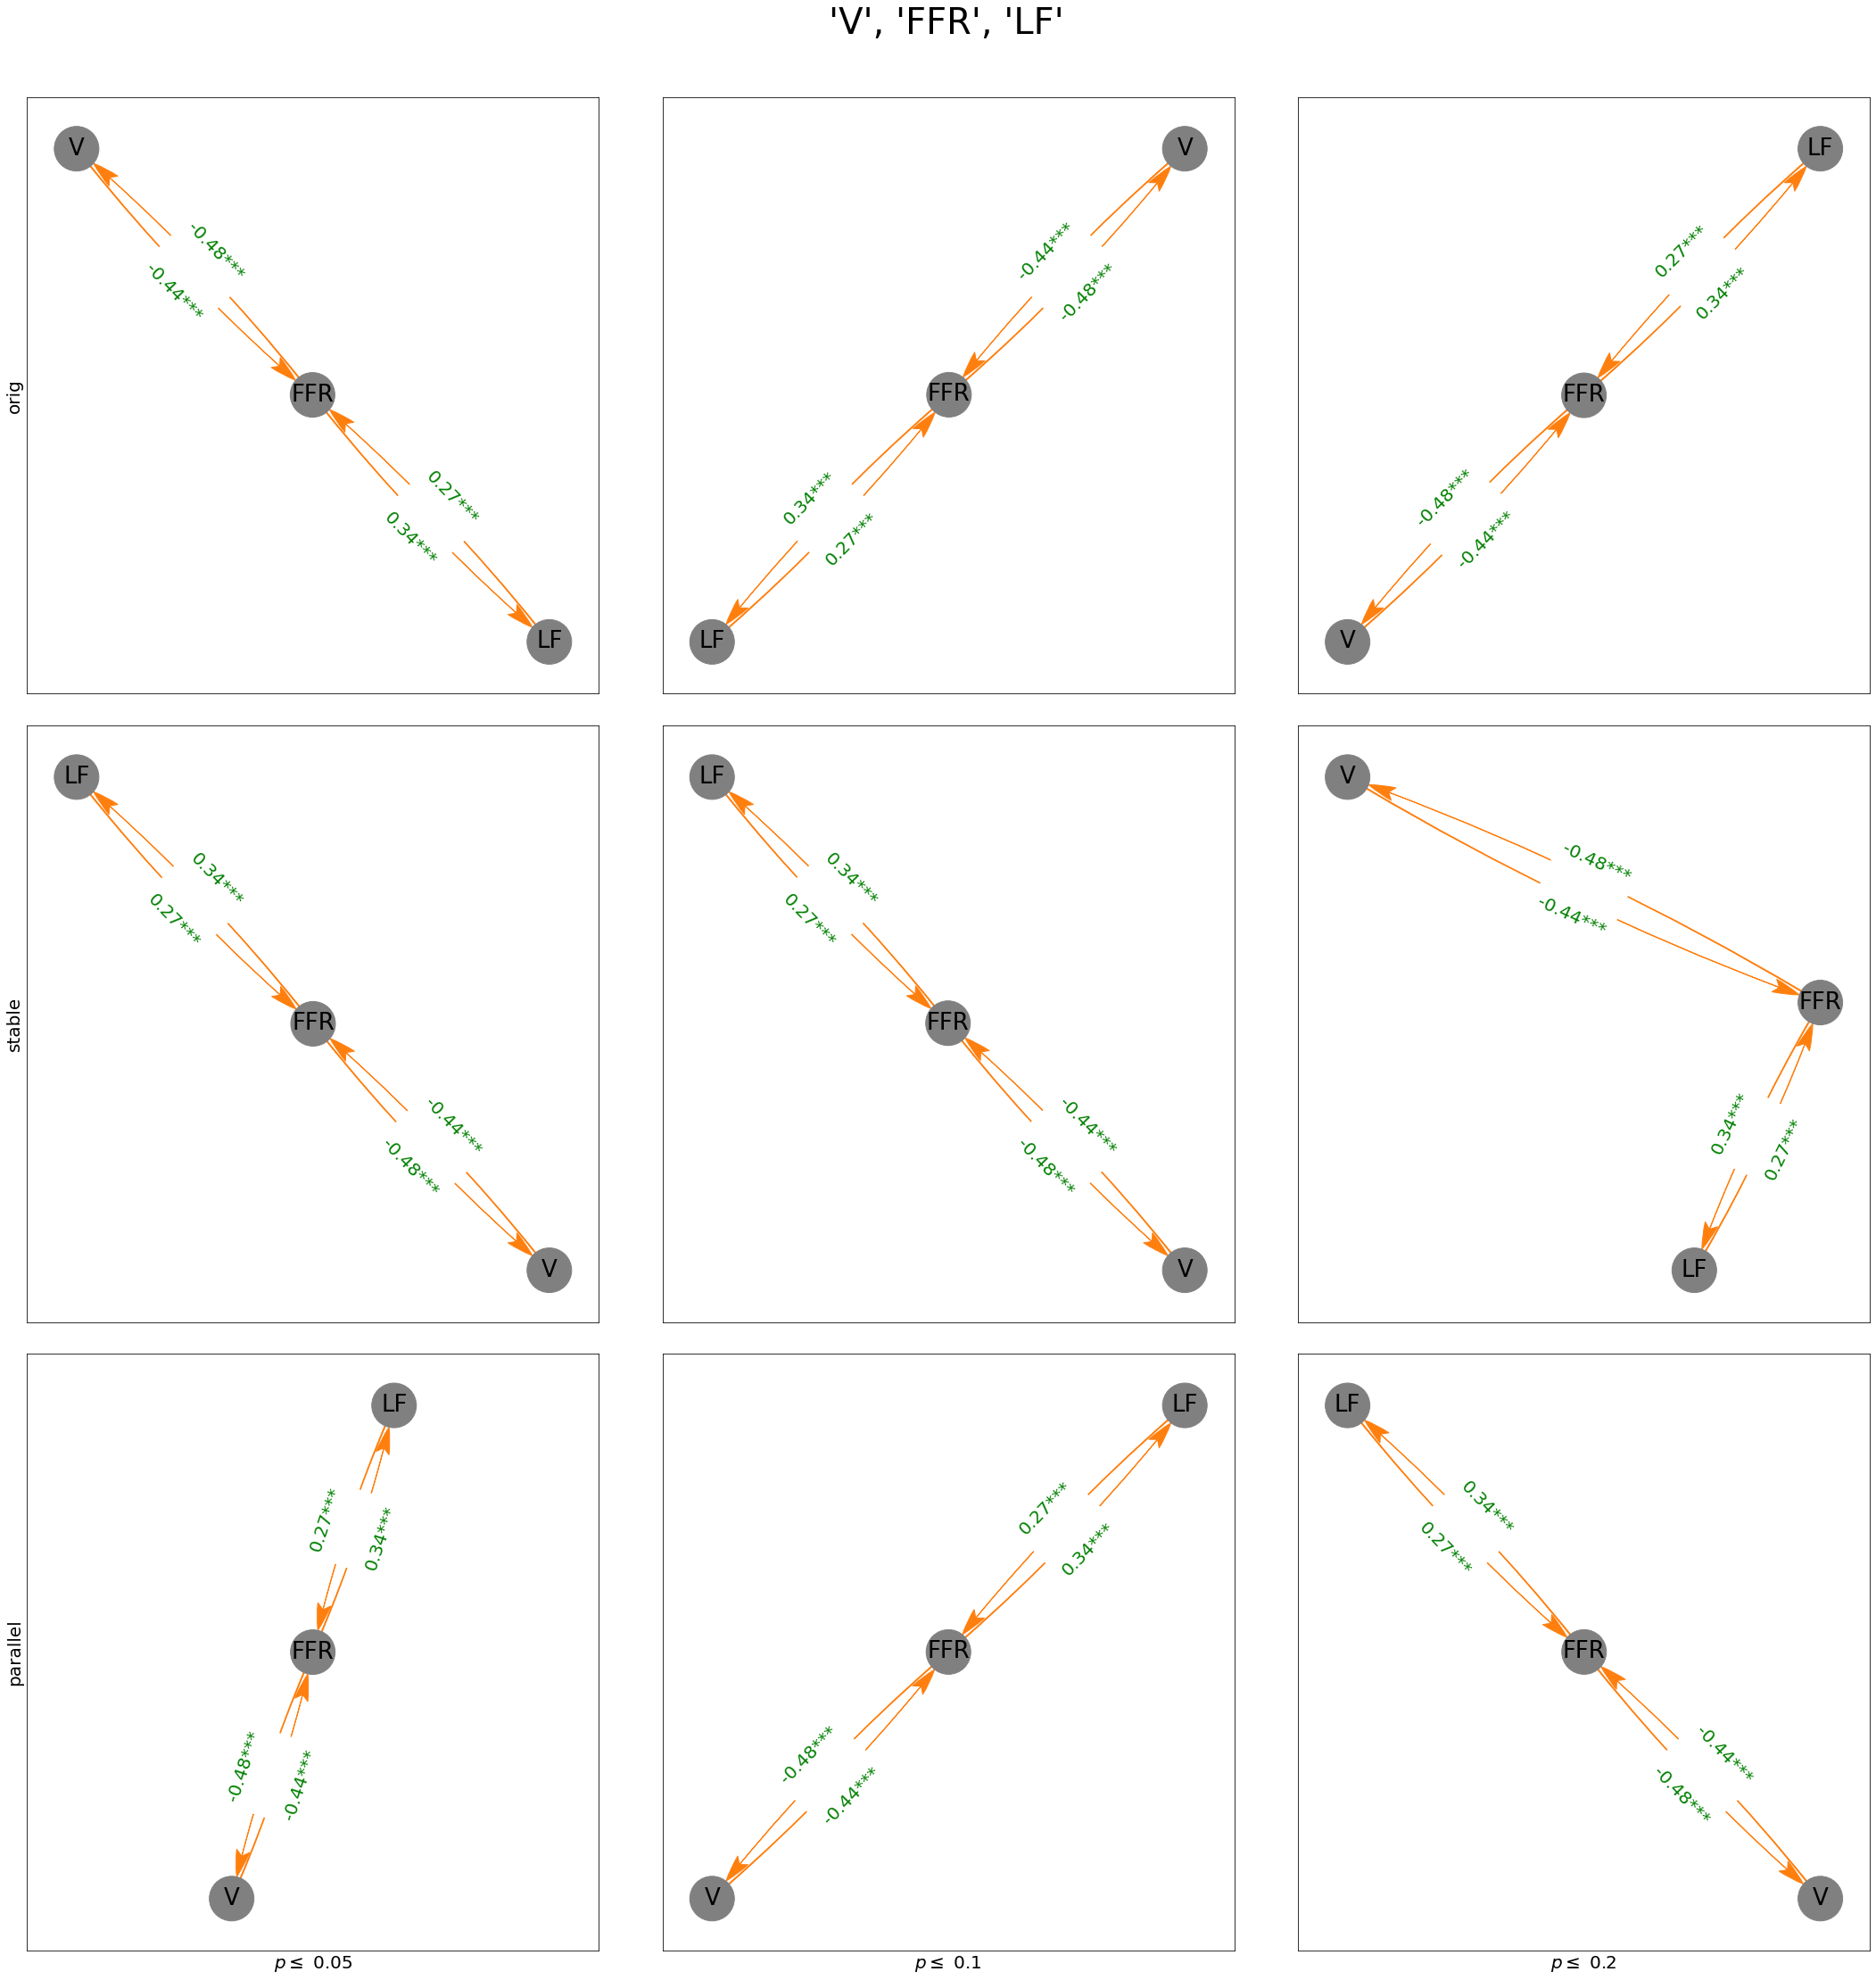

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

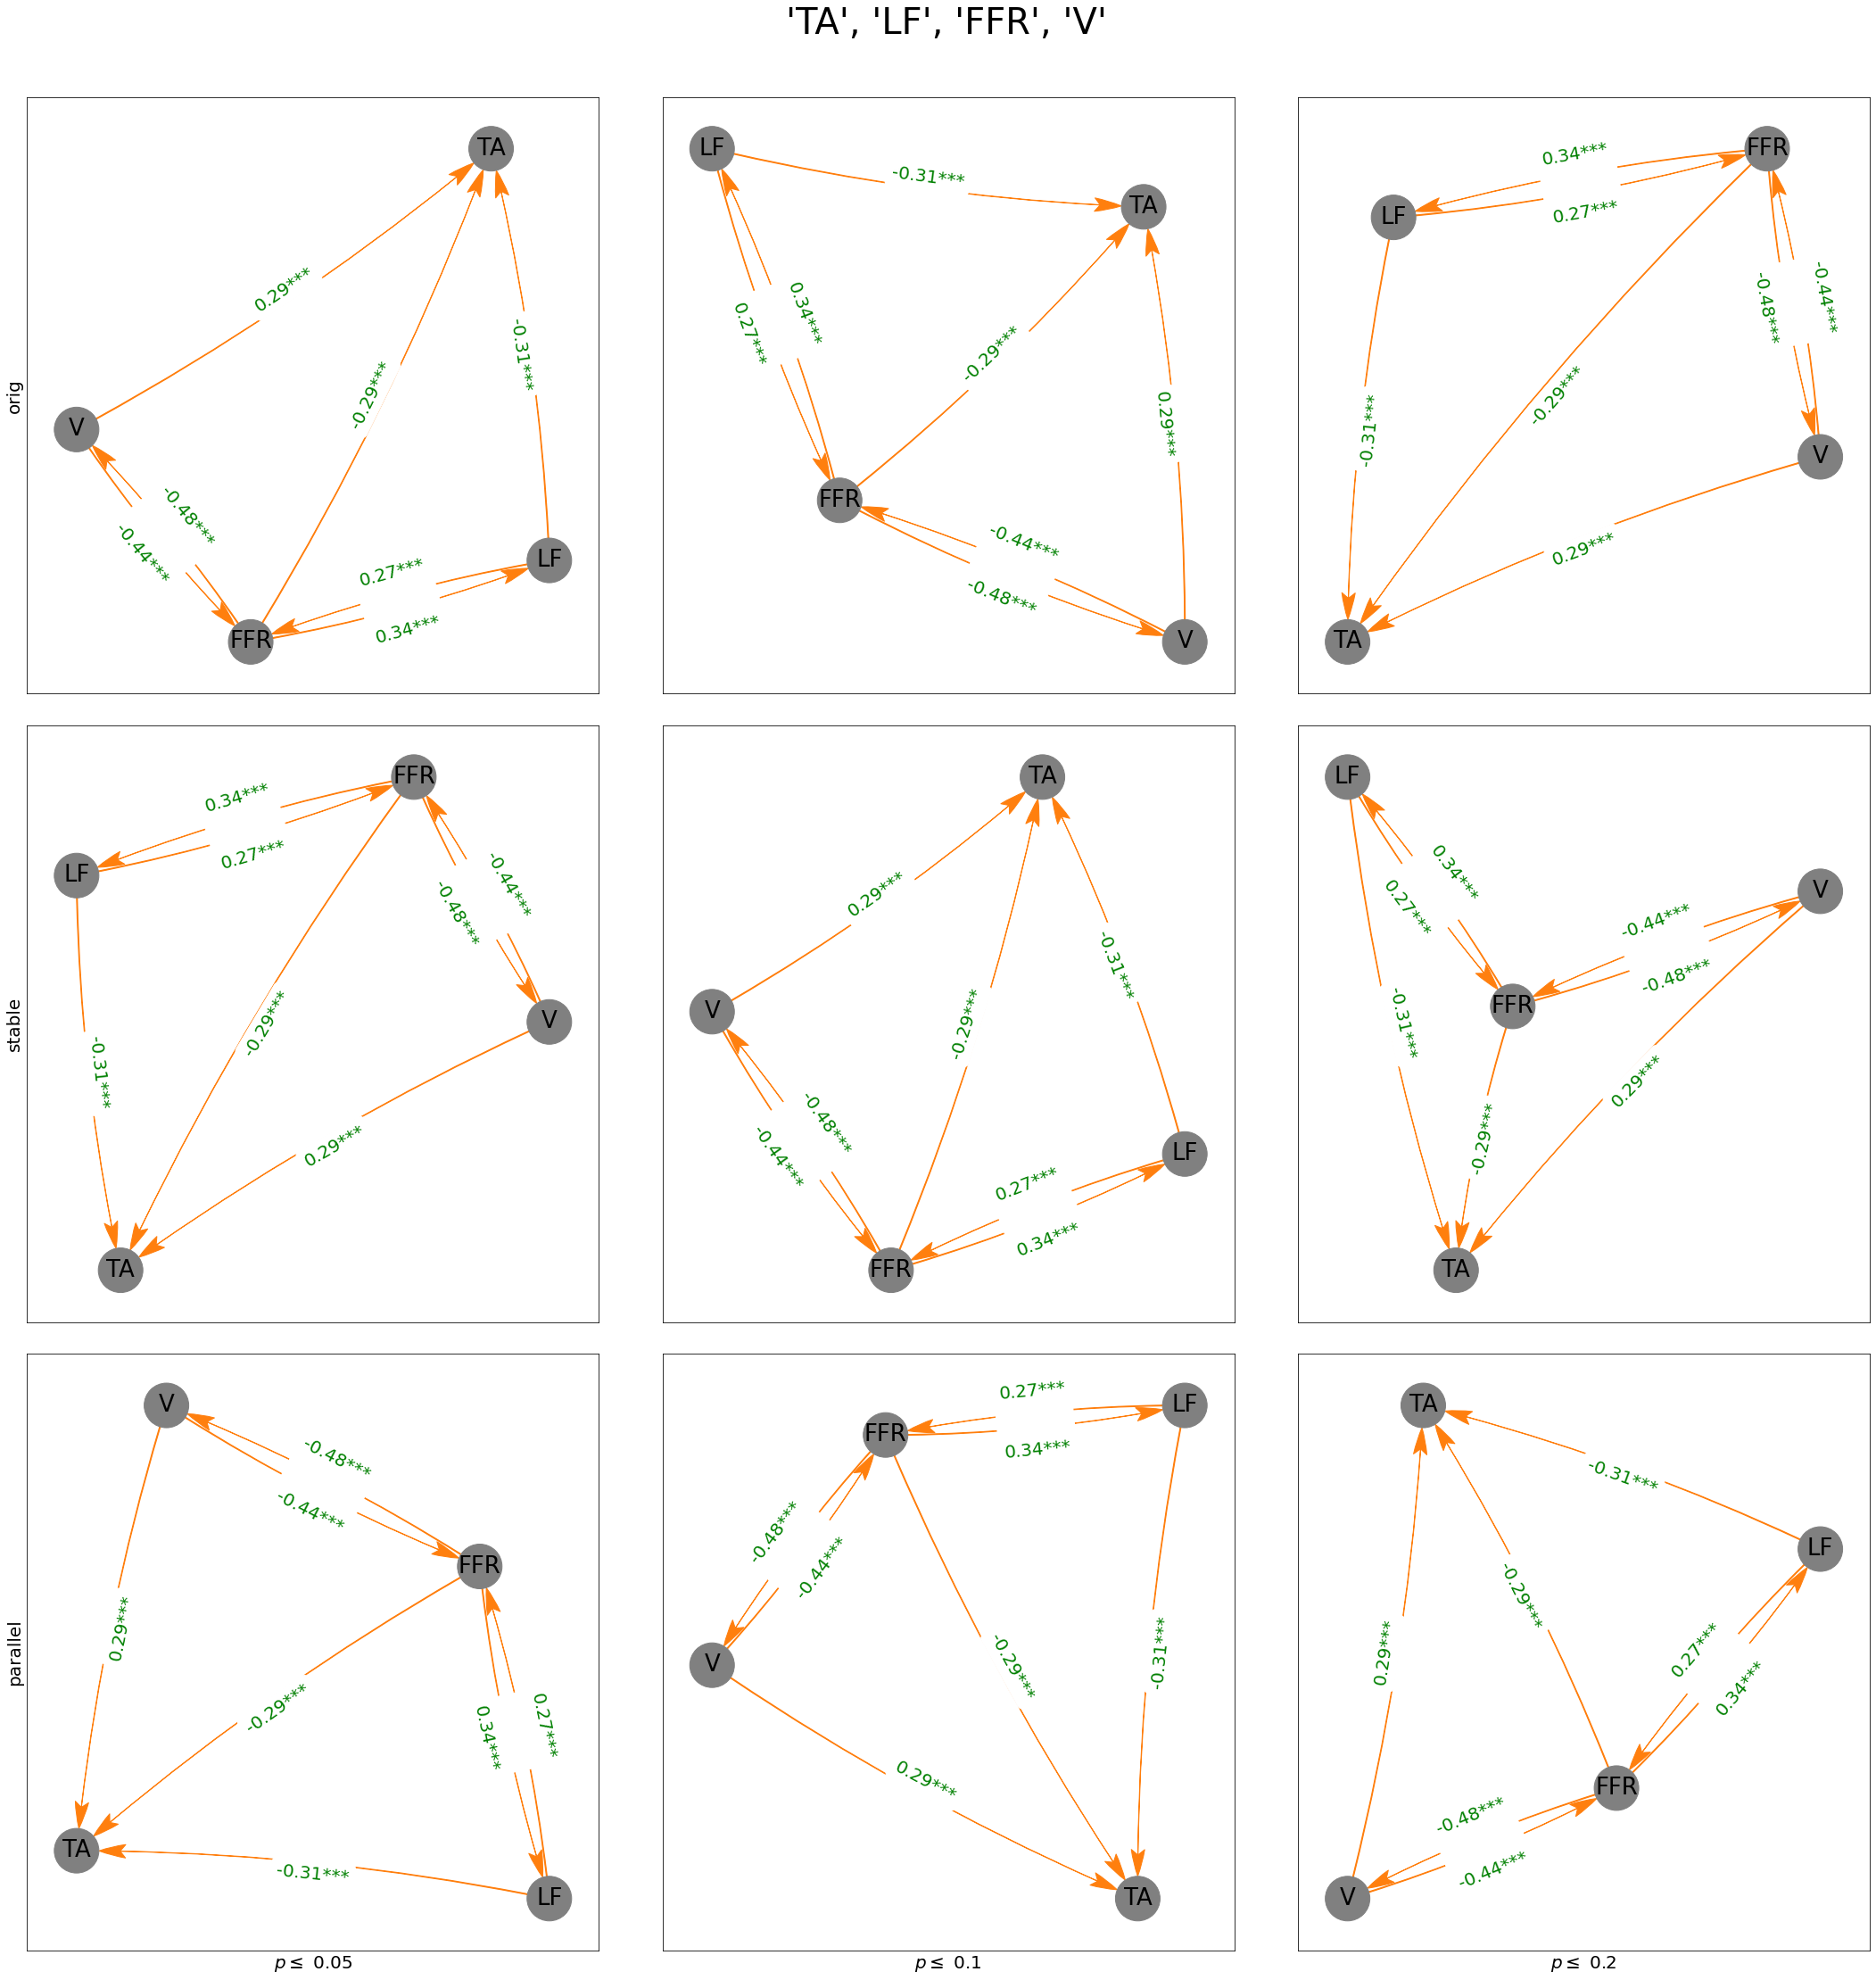

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

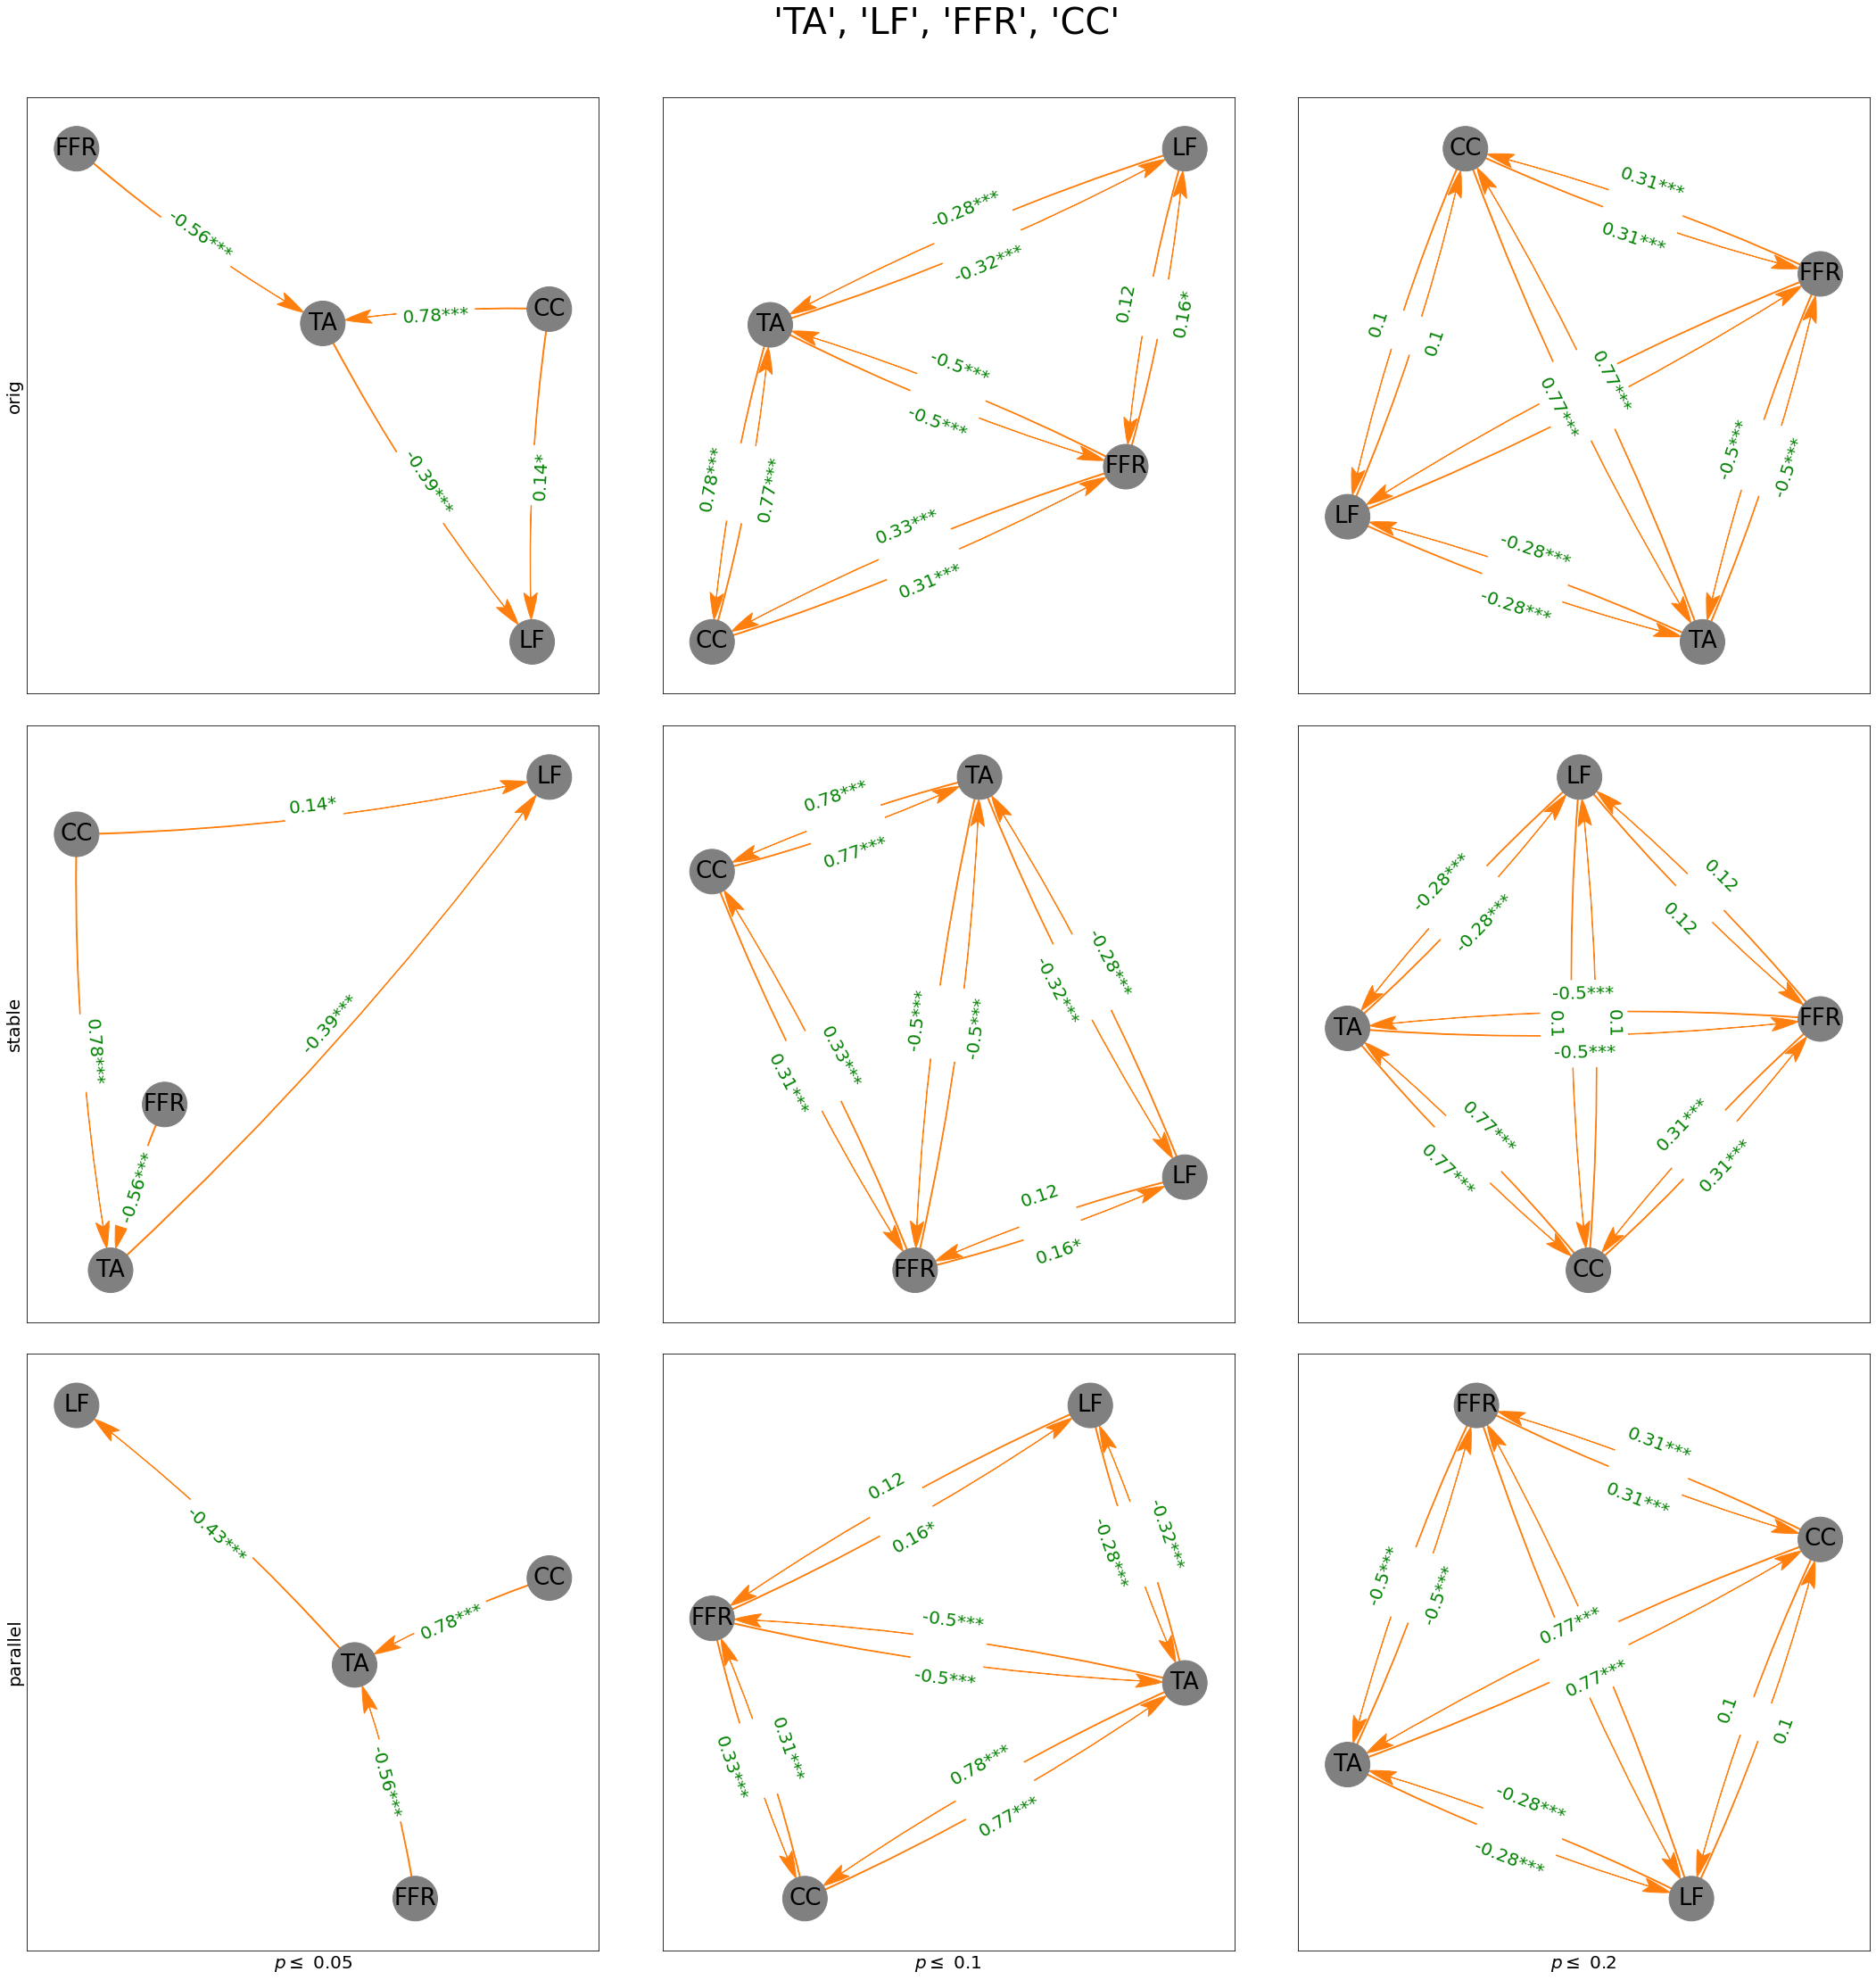

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

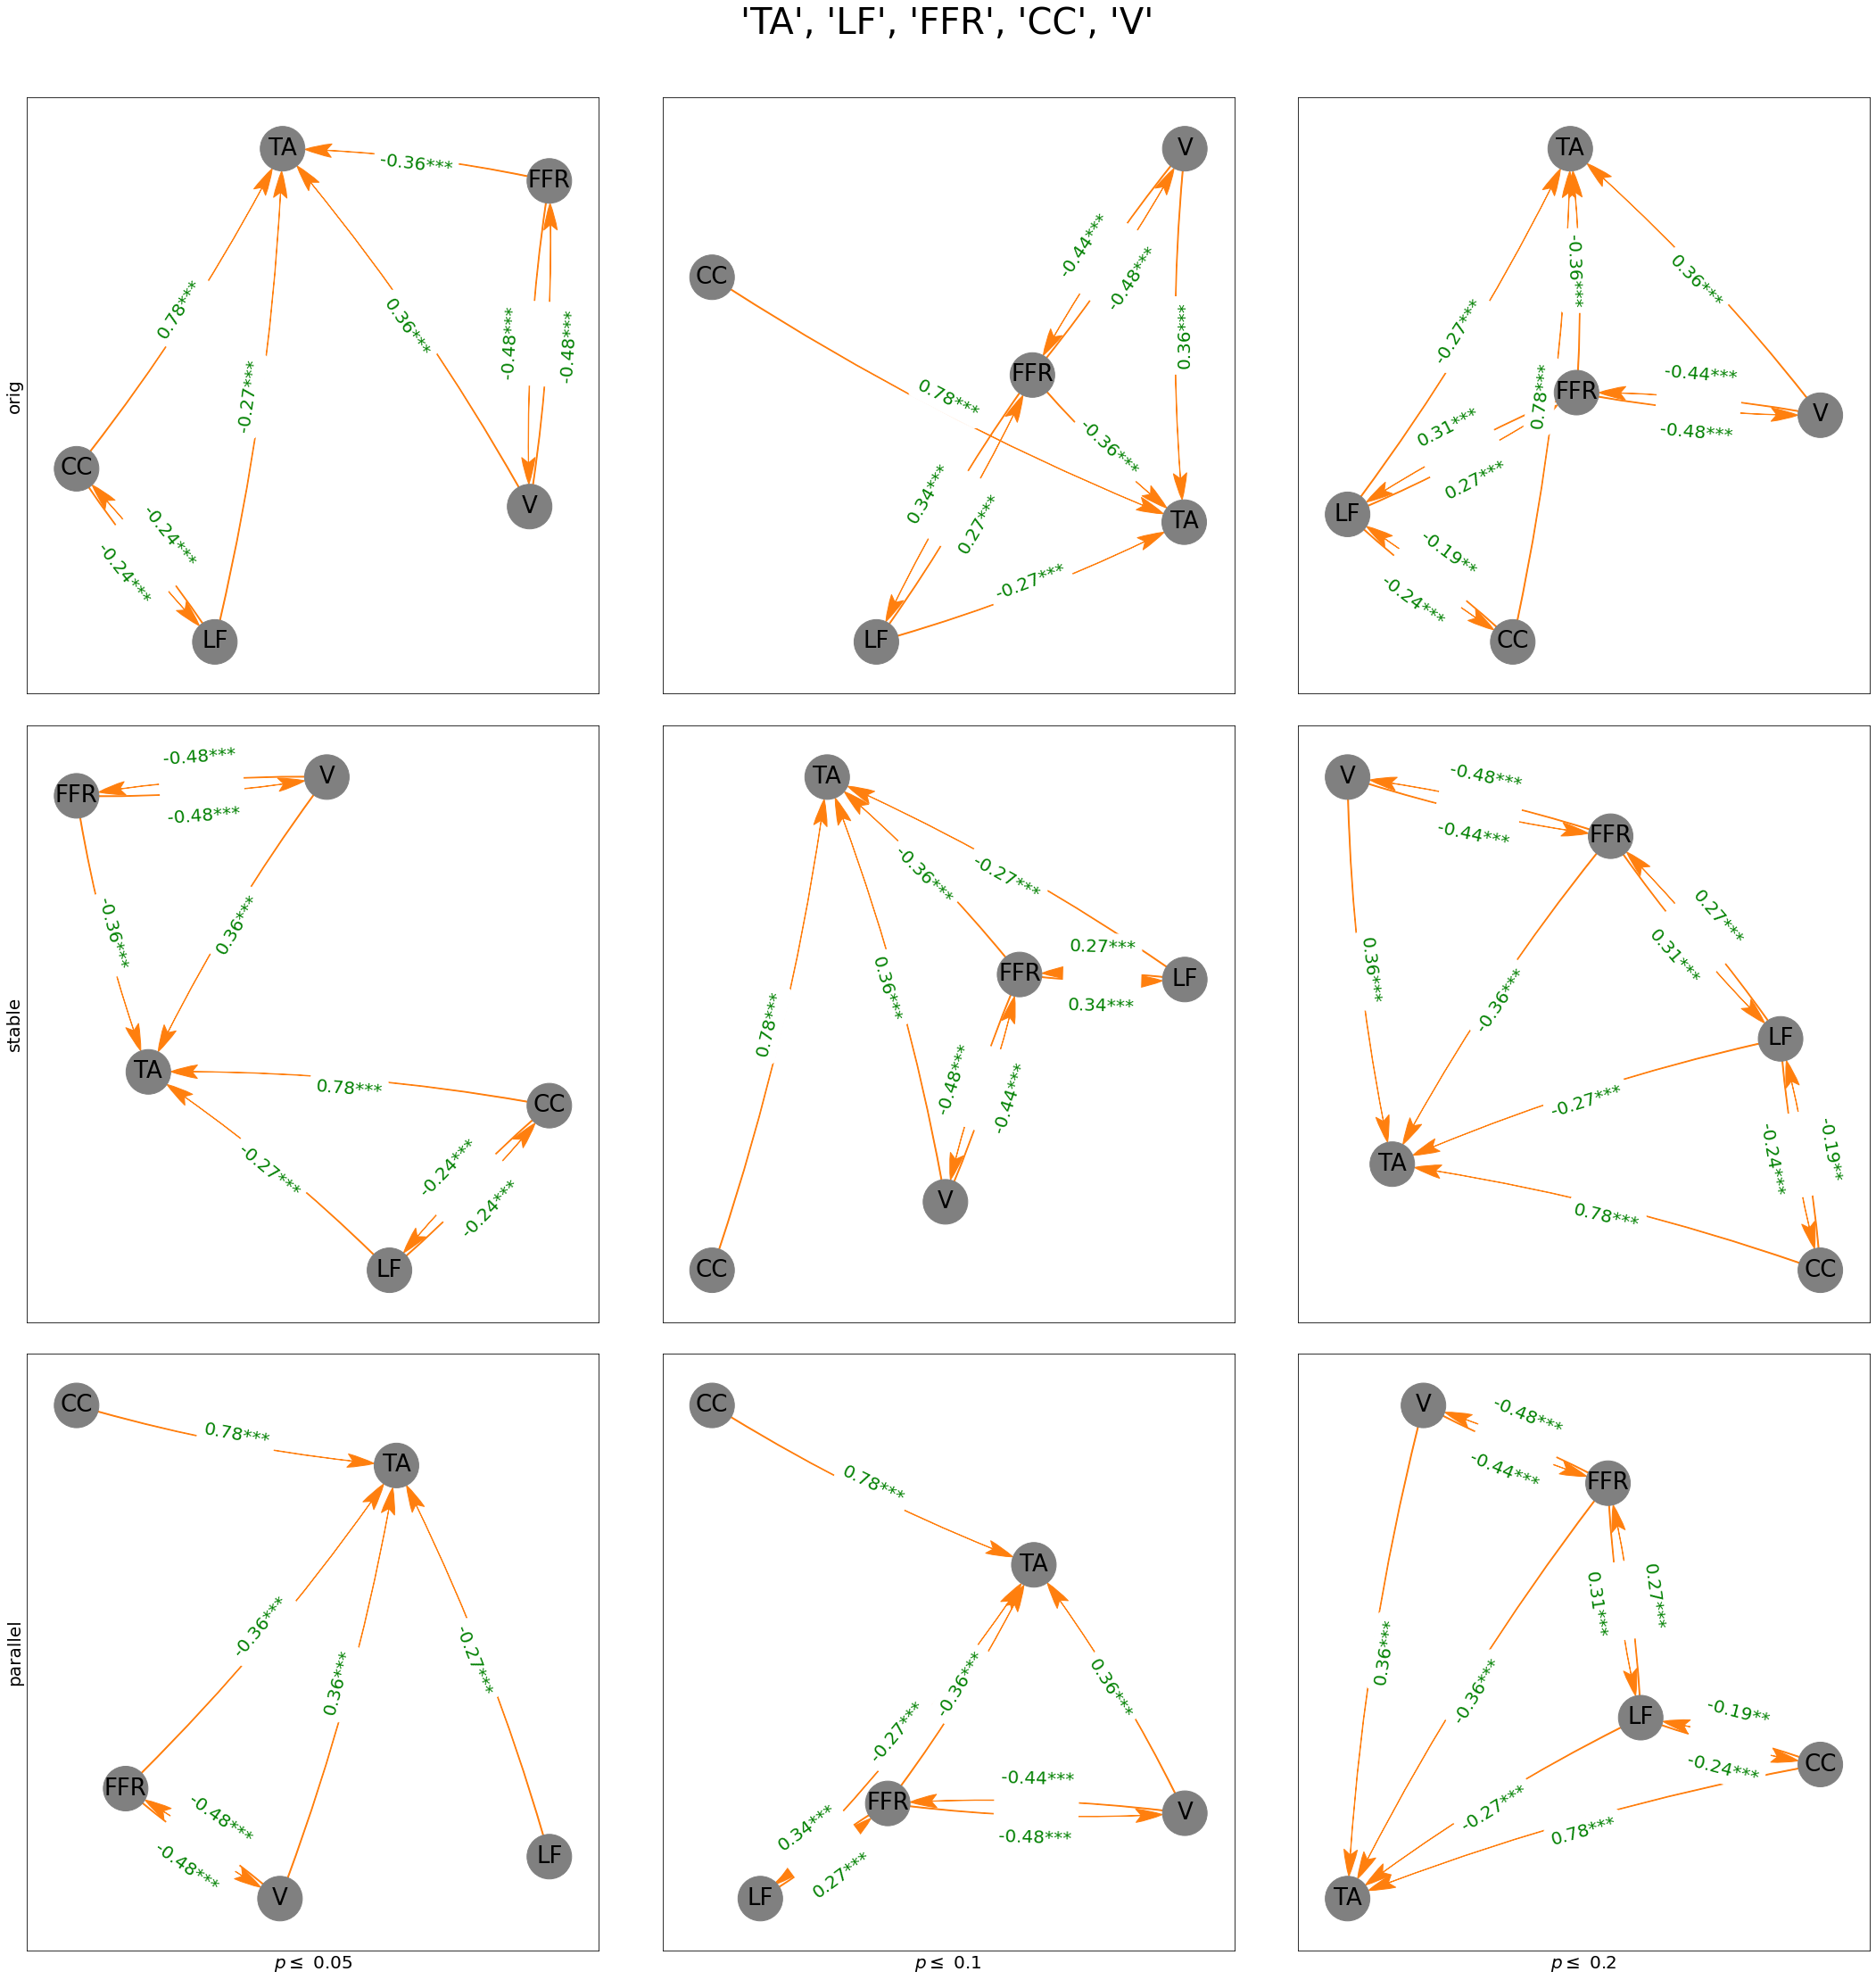

OutEdgeView([('V', 'TA'), ('V', 'FFR'), ('FFR', 'TA'), ('FFR', 'LF'), ('FFR', 'V'), ('LF', 'TA'), ('LF', 'FFR'), ('LF', 'CC'), ('CC', 'TA'), ('CC', 'LF')])

In [31]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    #pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {1:["V", "CC", "LF"],
                  2:["V", "FFR", "LF"],
                  3:["TA", "LF", "FFR", "V"],
                  4:["TA", "LF", "FFR", "CC"],
                  5:["TA", "LF", "FFR", "CC","V"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges